Branin synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/branin.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Branin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Branin':
    
    # True y bounds:
    operator = -1
    y_lb = 0.397887 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -5 
    ub_x1 = +10
    lb_x2 = +0 
    ub_x2 = +15

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y \t GP EI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def acqfuncApproxMeanTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = df1 + df2

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApproxMeanTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncApprox_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncApprox_exploit)
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        min_acqfuncApprox_exploit = self.min_acqfuncApprox_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
            min_acqfuncApprox_exploit = BOLD + OKGREEN + str(min_acqfuncApprox_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox, min_acqfuncApprox_exploit))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP dEI: maximum y \t GP dEI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncExactExploitTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = -(df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return -f, np.asarray(df_arr).transpose()

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExactExploitTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncExact_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncExact_exploit)
            
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        min_acqfuncExact_exploit = self.min_acqfuncExact_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
            min_acqfuncExact_exploit = BOLD + OKGREEN + str(min_acqfuncExact_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact, min_acqfuncExact_exploit))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 27.68166688936483	 27.68166688936483
2  	 [ 8.98893195 10.45227242]	 70.52424256621515	 5.089934878453152	 5.093418823776248	 5.062121444888492
3	 [-3.98443869 13.27643184]	 4.856556129138367	 4.856556129138367	 5.0934173844556945	 5.062120149803852
4  	 [2.90512774 0.        ]	 6.749370292693687	 4.856556129138367	 4.861548934817805	 4.819715310543853
5  	 [ 5.3348007 15.       ]	 206.4244586271804	 4.856556129138367	 4.86154

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 6.6922650079064745	 6.689308467376912
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 6.692265007906303	 6.68930846737674
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 1.684590944528292	 1.0597463773791687
4  	 [-2.58611214 14.70647972]	 15.728927661559513	 1.3984593420568778	 1.6845899705558112	 1.0597453219924597
5  	 [-4.49465842  0.        ]	 256.405875659363	 1.398459342056877

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 18.07886745449891	 18.07886745449891
2	 [-5. 15.]	 17.508299515778166	 17.508299515778166	 18.07886745449889	 18.07886745449889
3	 [2.64492238 0.66856133]	 5.661284999877455	 5.661284999877455	 17.508297558832044	 17.508297558832044
4  	 [10.  0.]	 10.960889035651505	 5.661284999877455	 5.662656051008728	 5.648133568146241
5  	 [ 0.17572036 15.        ]	 105.49246408403764	 5.661284999877455	 5.66262342313561	 5.648029686837

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [ 1.25164457 13.57001383]	 100.61648848019335	 7.247126865776948	 7.247197909829161	 7.246073949949372
2  	 [-4.27198795  1.64727177]	 188.41076037632916	 7.247126865776948	 7.247197409325942	 7.246073448426794
3  	 [-4.64886205 10.90918479]	 37.28607541173125	 7.247126865776948	 7.2471964679364484	 7.246072513009213
4  	 [3.91133965 8.49906097]	 48.63781804318897	 7.247126865776948	 7.247185995789564	 7.246062012367481
5  	 [1.2501607 0.       ]	 30.769010850910195	 7.247126865776948	 7.2471

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 25.311309180989422	 25.311309180989422
2  	 [ 8.39476442 14.47736321]	 167.21523769473345	 5.96108856337545	 5.961907098265746	 5.952512433999762
3  	 [-4.14019794  7.24510313]	 61.933263744898504	 5.96108856337545	 5.961905563429438	 5.952510328250705
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.961890642882623	 5.9524957478968625
5  	 [3.90128236 0.        ]	 6.125408773900473	 5.96108856337545	 5.961875502097774

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [ 9.64829531 12.55362889]	 98.32295673962142	 15.31731051317483	 15.317310503173594	 15.317310503173449
2  	 [-1.22578785  0.62063252]	 69.8637190838968	 15.31731051317483	 15.317310503035172	 15.317310503035026
3  	 [ 4.11366061 15.        ]	 183.1048464690602	 15.31731051317483	 15.317309952766703	 15.317309952766015
4	 [-2.66581011 14.57032849]	 13.089071799586758	 13.089071799586758	 15.317309277235875	 15.31730927723573
5  	 [-5.          4.21692696]	 180.95588650406685	 13.0890717995867

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 5.214210673253922	 5.187442543130133
2  	 [ 7.42679792 14.12713902]	 178.37635728719692	 5.211335324193094	 5.214210654642059	 5.187442523866203
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.214210312347393	 5.1874421695792226
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 5.214210673253922	 5.187442543130133
5  	 [4.5745799  5.89625789]	 28.693235382945684	 5.211335324193094	 5.

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 15.416245458468238	 15.416245458468138
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 6.499606274426392	 6.495543549232031
3  	 [ 1.38233826 12.68601766]	 86.43509303241686	 6.499298445992174	 6.499605297753907	 6.495542544257884
4  	 [-5.         4.9331771]	 162.88875202992193	 6.499298445992174	 6.499605152622068	 6.495542394704709
5  	 [4.45960766 1.26264545]	 7.642172669057232	 6.499298445992174	 6.4

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 3.497841782110876	 3.31979783164339
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 3.4978417820600054	 3.3197978315843355
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 3.497841747459437	 3.3197977914170287
4  	 [7.59811302 8.71517261]	 66.45196249675806	 3.4640248583909496	 3.4978407603382	 3.3197969365149596
5  	 [1.75712256 9.14412423]	 38.93294557365744	 3.464024858390949

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 2.791471383796652	 2.4729984549295345
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 2.7914713837968415	 2.4729984549297694
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 2.7914713830067637	 2.472998453952799
4  	 [ 1.02022796 14.99263201]	 124.89402405246402	 2.710610964564512	 2.791469993641612	 2.4729970990230457
5  	 [-5. 15.]	 17.508299515778166	 2.710610964564512	 2.79139679146

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 22.374358429523117	 22.374358429523117
2	 [9.97230855 6.82110601]	 16.589650805576685	 16.589650805576685	 17.615402292780683	 17.615402292780683
3  	 [-5. 15.]	 17.508299515778166	 16.589650805576685	 16.58965079556952	 16.58965079556952
4	 [2.40781929 2.48994243]	 3.051168412611748	 3.051168412611748	 16.589423570025154	 16.589423570025154
5  	 [ 4.54061416 15.        ]	 192.31887539788474	 3.051168412611748	 3.106127517221

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [10.          4.42353593]	 3.9611862792252275	 0.5499315281120278	 1.1032403857304094	 0.33583699444422843
2  	 [ 8.50155249 13.79797306]	 148.00655208378976	 0.5499315281120278	 1.1028242099285575	 0.3345391402651518
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 1.1028242099285575	 0.3345391402651517
4  	 [5.82026378 8.50131991]	 73.17953807026612	 0.5499315281120278	 1.1028231615217545	 0.33453813878503036
5  	 [3.15979756 0.59150564]	 3.186174209194043	 0.

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-5.         10.55852145]	 56.665255254022	 18.038943061558626	 18.038943051558626	 18.038943051558626
2  	 [-3.36042638  1.3238031 ]	 132.49290788011677	 18.038943061558626	 18.038943051558626	 18.038943051558626
3  	 [-0.52477309  6.71287575]	 18.334962929598774	 18.038943061558626	 18.03894166733079	 18.03894166733079
4  	 [-0.84251917 15.        ]	 73.65639591438165	 18.038943061558626	 18.038942202567238	 18.038942202567238
5	 [2.39368641 0.        ]	 11.548515885786035	 11.5485

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [-5.          5.52357421]	 148.76765257173	 1.4149920024014744	 1.697140747475291	 1.0759186619938361
2  	 [ 9.02510452 14.92575454]	 164.15736583327134	 1.4149920024014744	 1.6971407472101587	 1.075918661763138
3  	 [8.4415984  6.61360555]	 28.132050221972662	 1.4149920024014744	 1.6971407168951451	 1.075918622686731
4  	 [-1.09394501  0.        ]	 76.74873707612674	 1.4149920024014744	 1.6971406025087192	 1.0759171965886254
5  	 [-2.07607151  9.6649294 ]	 5.390544119887941	 1.414992002

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [ 6.5655417  11.87699252]	 134.95011349993544	 12.768724532005583	 12.768724522031354	 12.768724520906746
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 12.768724521196418	 12.76872452007181
3  	 [ 0.6952482 15.       ]	 118.25691358098898	 12.768724532005583	 12.76872348454927	 12.768723483429449
4	 [2.88465109 0.        ]	 6.882901559170483	 6.882901559170483	 12.768721669484274	 12.76872166723098
5  	 [10.         7.3920374]	 21.207170929206335	 6.882901

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 2.7962650410643577	 2.4789248717510164
2  	 [9.4202829  9.76772141]	 53.637049482645274	 2.715864006988424	 2.796264377546995	 2.47892405160541
3  	 [-4.02259831  0.        ]	 213.9230769501899	 2.715864006988424	 2.796262955464986	 2.4789205965053522
4  	 [3.77183963 8.41852715]	 45.58796263948214	 2.715864006988424	 2.7962619681171716	 2.4789204287686006
5  	 [10.  0.]	 10.960889035651505	 2.715864006988424	 2.79625796460850

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [10.  0.]	 10.960889035651505	 10.960889035651505	 19.016141107164255	 19.016141107164255
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 10.960889035651505	 10.960889028171572	 10.960888788363556
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 10.96088841225565	 10.960888172447234
4  	 [10.         14.81517083]	 141.47154557588692	 2.3563457989420957	 2.473666220784963	 2.0750816669562373
5  	 [-5.         11.26935865]	 47.74649486673399	 2.3563457989420957	 2.473

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1  	 [-4.83474958 11.77354131]	 35.58412906267954	 8.150075223157177	 8.150085433802543	 8.149887733241535
2  	 [-1.00357121  6.84655739]	 15.934937141101628	 8.150075223157177	 8.15008415447532	 8.149886671261145
3  	 [10.         7.3720746]	 21.032332692938766	 8.150075223157177	 8.150084445196063	 8.14988679078149
4  	 [-0.65340519 15.        ]	 80.11200680341189	 8.150075223157177	 8.150058222742361	 8.14986051121654
5  	 [10. 15.]	 145.87219087939556	 8.150075223157177	 8.150085433771585	

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 4.484380377136809	 4.4191398862311475
2  	 [4.35925134 5.04996868]	 19.16147327361864	 0.8198597583535783	 1.2739298753963988	 0.5403457981360908
3  	 [-5.          6.34813718]	 130.21250516921657	 0.8198597583535783	 1.273927449390786	 0.5403423425843261
4  	 [ 0.06675761 15.        ]	 102.49399255751578	 0.8198597583535783	 1.2739245457656516	 0.5403388013750416
5  	 [10. 15.]	 145.87219087939556	 0.8198597583535783	 1.27392

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-0.46683041  1.12730576]	 50.42750988022418	 14.042667401507376	 14.042666445779654	 14.042667194626693
2	 [10.          5.93633926]	 10.547874467067842	 10.547874467067842	 14.042667217222407	 14.042667217206676
3	 [10.          0.32520612]	 9.113488331150725	 9.113488331150725	 10.547873232238413	 10.547872612311863
4  	 [-2.95527783 15.        ]	 10.602030856014657	 9.113488331150725	 9.113489366902959	 9.113464643235233
5  	 [-5.          4.58919409]	 171.43753769458684	 9.11348

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 27.68166688936483	 27.68166688936483
2  	 [ 8.98893195 10.45227242]	 70.52424256621515	 5.089934878453152	 5.093418823776248	 5.0621214448913125
3  	 [3.1784986 0.       ]	 5.450714203742865	 5.089934878453152	 5.0934172630199805	 5.062118619598452
4  	 [-4.67712792 14.21955317]	 13.865244792739254	 5.089934878453152	 5.0934188219075285	 5.062121442944941
5  	 [ 5.30676004 15.        ]	 206.03558952485747	 5.089934878453152	

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 6.6922650079064745	 6.689308467376918
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 6.692265007906303	 6.68930846737674
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 1.684590944528292	 1.0597463773791687
4  	 [-5.          0.47652372]	 291.9758016736889	 1.3984593420568778	 1.6845902571525213	 1.0593296095318294
5  	 [9.02917984 6.38725122]	 18.99628463361546	 1.398459342056877

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 18.07886745449891	 18.07886745449891
2	 [-3.89564496 13.38589781]	 3.6010193697779265	 3.6010193697779265	 18.078867447127802	 18.078867447127802
3  	 [ 0.53511805 15.        ]	 114.58765716763713	 3.6010193697779265	 3.62945032452176	 3.4716740212804793
4  	 [3.11133413 0.        ]	 5.686376470456184	 3.6010193697779265	 3.629533318036846	 3.4717742141408356
5  	 [9.70346787 8.50929412]	 34.28297118578492	 3.6010193697779

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [-5.  0.]	 308.12909601160663	 7.247126865776948	 7.24719790983207	 7.246073949955741
2  	 [ 1.1294018  14.15696259]	 109.93986979623045	 7.247126865776948	 7.247197909835409	 7.2460739499556315
3  	 [1.01107069 0.        ]	 35.554826707809156	 7.247126865776948	 7.24719303389414	 7.24606430585531
4  	 [3.23218268 8.99706827]	 46.56384602934775	 7.247126865776948	 7.247168110546214	 7.246049348323823
5  	 [-4.71931664 12.72607102]	 23.47782987479111	 7.247126865776948	 7.247197172880776	 7.

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 25.311309180989422	 25.311309180989422
2  	 [ 8.39476442 14.47736321]	 167.21523769473345	 5.96108856337545	 5.961907098265746	 5.952512434926683
3  	 [-5.          8.10986515]	 95.12466680670255	 5.96108856337545	 5.96190691908924	 5.952511370256219
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.961890642966492	 5.952495747981907
5  	 [4.68041959 2.64376529]	 11.288061329654056	 5.96108856337545	 5.961858176609415

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [10. 15.]	 145.87219087939556	 15.31731051317483	 15.31731050317483	 15.317310503174685
2  	 [-2.67838097  0.        ]	 126.61486786700603	 15.31731051317483	 15.317310503174827	 15.317310503174681
3  	 [ 4.34724927 14.59608757]	 177.48889452505895	 15.31731051317483	 15.31731050317483	 15.317310503174685
4  	 [-1.30746846 14.41632538]	 49.88755953556025	 15.31731051317483	 15.317284392562508	 15.317284392562383
5  	 [8.13676748 9.89528697]	 76.08522805324013	 15.31731051317483	 15.31723856

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 5.214210673253922	 5.187442543130133
2  	 [ 7.80155495 14.72615764]	 186.86153570538508	 5.211335324193094	 5.21421067254134	 5.187442542956664
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.214210312347393	 5.1874421695792226
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 5.214210673253922	 5.187442543130133
5  	 [4.93717413 5.49891249]	 29.845086555570777	 5.211335324193094	 5

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 15.416245458468238	 15.416245458468138
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 6.499606274426392	 6.495543549232031
3  	 [-0.06146391 15.        ]	 98.82405002647226	 6.499298445992174	 6.499605162879605	 6.495543539348084
4  	 [4.4595038 0.8533709]	 7.979766606771776	 6.499298445992174	 6.499603335514521	 6.495459983117531
5  	 [-5.         6.0933586]	 135.8006206439636	 6.499298445992174	 6.49

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 3.497841782110876	 3.31979783164339
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 3.4978417820600054	 3.3197978315843355
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 3.497841747459437	 3.3197977914170287
4  	 [4.57208176 9.16642126]	 68.60581850295517	 3.4640248583909496	 3.497841027786867	 3.3197978309854688
5  	 [10.          6.41094566]	 13.557530071759565	 3.46402485

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 2.791471383796652	 2.4729984549297694
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 2.7914713837968415	 2.4729984549297694
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 2.7914713830067637	 2.472998453952799
4  	 [ 0.96818967 15.        ]	 124.01515892955138	 2.710610964564512	 2.7914699746755316	 2.4729967832389046
5  	 [5.26562048 6.20098174]	 40.04142137111575	 2.71061096456451

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 22.374358429523117	 22.374358429523117
2	 [9.28738882 6.14578118]	 14.808790749874726	 14.808790749874726	 17.615402322258053	 17.615402322258053
3	 [2.54385739 0.04476512]	 9.58430283129103	 9.58430283129103	 14.808015906178486	 14.808015907214985
4  	 [ 4.54043559 15.        ]	 192.31515921238574	 9.58430283129103	 9.583961681286047	 9.581089538861795
5	 [-2.78845701 11.96288645]	 1.2612701228696341	 1.2612701228696341	 9

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [10.         4.2917554]	 3.604142984594371	 0.5499315281120278	 1.1031910701027643	 0.3356879734954516
2  	 [ 9.19833734 12.85785838]	 112.3096138370831	 0.5499315281120278	 1.1028242099285575	 0.3345391402651518
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 1.1028242099285575	 0.3345391402651517
4  	 [2.31082274 1.96051811]	 4.630930870259078	 0.5499315281120278	 1.1028242068712346	 0.3345390794121357
5  	 [4.84411484 8.7761414 ]	 66.82952699849903	 0.5499

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-5.  0.]	 308.12909601160663	 18.038943061558626	 18.038943051558626	 18.038943051558626
2	 [-3.06562888 11.40851515]	 0.8943531028899869	 0.8943531028899869	 18.038943051335508	 18.038943051335508
3  	 [-0.77721745  5.55115316]	 19.956248293009427	 0.8943531028899869	 1.3235330933561291	 0.6015653196102482
4  	 [-0.24948802 15.        ]	 93.17689500314201	 0.8943531028899869	 1.3235177097998942	 0.6015356591104736
5  	 [2.24297905 0.        ]	 13.507883026233038	 0.89435310288998

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [-4.22572169  4.73878507]	 111.46482334173054	 1.4149920024014744	 1.6971407473891316	 1.0759186621049575
2  	 [ 9.02510452 14.92575454]	 164.15736583327134	 1.4149920024014744	 1.6971407472101587	 1.0759186621048384
3  	 [8.4415984  6.61360555]	 28.132050221972662	 1.4149920024014744	 1.6971407168951451	 1.075918622686731
4  	 [-0.6348753  0.       ]	 67.61008168553072	 1.4149920024014744	 1.6971390234773085	 1.0758066510317743
5  	 [-2.40015779  9.60941637]	 3.8299944025381123	 1.414

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [10. 15.]	 145.87219087939556	 12.768724532005583	 12.768724522031357	 12.76872452090675
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 12.768724521196418	 12.76872452007181
3  	 [ 3.80261319 11.96078244]	 105.3381651976412	 12.768724532005583	 12.76872447075339	 12.768724469628783
4  	 [8.63272613 8.32488519]	 44.68998814179533	 12.768724532005583	 12.768723384052656	 12.768723382928044
5	 [2.63098807 0.01106722]	 8.890052611403327	 8.890052611403327	 12

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 2.7962650410643577	 2.4789248717510164
2  	 [-5.          0.76360453]	 282.4634960240413	 2.715864006988424	 2.796264877786649	 2.47892405160541
3  	 [6.4086727  8.01053377]	 67.19879991173286	 2.715864006988424	 2.796264138365111	 2.4789248716316714
4  	 [ 1.37630907 11.42929673]	 66.24718744041212	 2.715864006988424	 2.7961126043039553	 2.4787320360174343
5  	 [-5.         10.21600199]	 61.323587189474544	 2.71586400698842

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [9.76575296 0.98553483]	 4.1623278326263815	 4.1623278326263815	 19.016141107164255	 19.016141107164255
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 4.1623278326263815	 4.175953248370189	 4.084452939148241
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 4.175952634281328	 4.084452430351597
4  	 [10.         14.92965946]	 144.18938157396997	 2.3563457989420957	 2.4736666897768274	 2.075073780011422
5  	 [9.39679852 5.53959908]	 9.938002284241987	 2.356345798942

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1  	 [-4.83474958 11.77354131]	 35.58412906267954	 8.150075223157177	 8.150085433802543	 8.149887733241535
2  	 [-1.31027796  6.26018244]	 16.663442406570503	 8.150075223157177	 8.150083903898924	 8.149886819768827
3  	 [ 0.35908684 11.68414639]	 57.91470988730182	 8.150075223157177	 8.150043865074647	 8.149827501194284
4	 [4.16866889 0.        ]	 7.625670656251107	 7.625670656251107	 8.15002964654158	 8.149754981708007
5  	 [10. 15.]	 145.87219087939556	 7.625670656251107	 7.625702885044119

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 4.484380377136809	 4.4191398862311475
2  	 [5.03077312 4.64729248]	 24.460797393473307	 0.8198597583535783	 1.2739300535480347	 0.5403441727766556
3  	 [0.20107266 7.62370777]	 23.16644757636532	 0.8198597583535783	 1.273927588153038	 0.5403167397073474
4  	 [ 0.09562252 15.        ]	 103.29917138491766	 0.8198597583535783	 1.2739245602064833	 0.5403387160529388
5  	 [10. 15.]	 145.87219087939556	 0.8198597583535783	 1.27392

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-5.  0.]	 308.12909601160663	 14.042667401507376	 14.042667391507678	 14.042667391491946
2	 [10.          5.49820193]	 8.169389869926185	 8.169389869926185	 14.042666918413207	 14.042666918414772
3  	 [0.61138061 0.18064926]	 41.819817406212465	 8.169389869926185	 8.169357898860278	 8.169116967176258
4  	 [-1.2637238 15.       ]	 58.90356087528688	 8.169389869926185	 8.169399645127884	 8.169209582792323
5  	 [-4.79483707  5.40415968]	 136.16520405222136	 8.169389869926185	 8.16925

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(1.494850319962892, 1.4126163322006093)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.0005721783316311656, -0.4683609617144654)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(1.0416914731710387, 1.164129196584808)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-1.6231328232201476, -0.6218785690047403)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(0.8523502042428276, -3.7276820293567514)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-1.9052643768006903, -0.4275476630166717)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(0.786802785982127, 0.8035858166782609)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(1.8085201290028612, 1.1849445155103453)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(0.58909769360436, 0.9209595469246515)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.6062840276442628, 0.4448402062315973)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.5207449290394924, -0.1604760823663512)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-1.8835818529313322, -1.8835818529313322)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.4933987297393712, -1.8980258931472425)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.016960358935887654, 0.016960358935887654)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(1.1189581410547993, 0.8098759117076586)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.8406948255363631, 0.8406948255363631)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(0.48250411714932395, 0.3736586777309336)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(1.2124189838306905, 0.9861761147798177)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-4.114542976529597, -0.8628145206943092)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(1.731344480393983, 0.44085944183359826)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def extractAcqFuncMax(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-3]
    return new_array

def exploitExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-3]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-3] * -1
    return new_array


In [97]:
approx1_acqFuncMax = extractAcqFuncMax(approx_1.history) + eps
approx1_exploit = exploitExtract(approx_1.history) + eps
approx1_ratio = approx1_exploit/approx1_acqFuncMax 

np.round(approx1_acqFuncMax, 3), np.round(approx1_exploit,3)


(array([27.682,  5.093,  5.093,  4.862,  4.862,  4.862,  4.86 ,  4.86 ,
         4.859,  4.858,  4.857,  4.834,  4.799,  4.621,  4.6  ,  4.545,
         4.424,  4.545,  4.374,  4.345]),
 array([27.682,  5.062,  5.062,  4.82 ,  4.82 ,  4.82 ,  4.818,  4.817,
         4.817,  4.816,  4.814,  4.754,  4.754,  4.565,  4.485,  4.485,
         4.354,  4.301,  4.301,  4.269]))

In [98]:
approx2_acqFuncMax = extractAcqFuncMax(approx_2.history) + eps
approx2_exploit = exploitExtract(approx_2.history) + eps
approx2_ratio = approx2_exploit/approx2_acqFuncMax

np.round(approx2_acqFuncMax, 3), np.round(approx2_exploit, 3)


(array([6.692, 6.692, 1.685, 1.685, 1.685, 1.685, 1.684, 1.684, 1.681,
        1.673, 1.671, 1.63 , 1.622, 1.573, 1.466, 1.412, 1.559, 1.39 ,
        1.372, 1.386]),
 array([6.689, 6.689, 1.06 , 1.06 , 1.06 , 1.06 , 1.06 , 1.059, 1.055,
        1.045, 1.043, 0.989, 0.98 , 0.916, 0.78 , 0.712, 0.903, 0.685,
        0.662, 0.68 ]))

In [99]:
approx3_acqFuncMax = extractAcqFuncMax(approx_3.history) + eps
approx3_exploit = exploitExtract(approx_3.history) + eps
approx3_ratio = approx3_exploit/approx3_acqFuncMax

np.round(approx3_acqFuncMax, 3), np.round(approx3_exploit, 3)


(array([18.079, 18.079, 17.508,  5.663,  5.663,  5.663,  5.663,  5.659,
         5.663,  5.647,  5.657,  5.608,  5.637,  5.604,  5.586,  3.041,
         2.911,  3.014,  2.984,  2.417]),
 array([18.079, 18.079, 17.508,  5.648,  5.648,  5.648,  5.648,  5.645,
         5.648,  5.632,  5.642,  5.622,  5.622,  5.393,  5.57 ,  2.779,
         2.743,  2.745,  2.71 ,  1.598]))

In [100]:
approx4_acqFuncMax = extractAcqFuncMax(approx_4.history) + eps
approx4_exploit = exploitExtract(approx_4.history) + eps
approx4_ratio = approx4_exploit/approx4_acqFuncMax

np.round(approx4_acqFuncMax, 3), np.round(approx4_exploit, 3)


(array([7.247, 7.247, 7.247, 7.247, 7.247, 7.247, 7.243, 2.945, 2.941,
        2.933, 2.9  , 2.916, 2.778, 2.824, 2.727, 2.734, 2.524, 2.392,
        2.604, 2.205]),
 array([7.246, 7.246, 7.246, 7.246, 7.246, 7.246, 7.242, 2.662, 2.647,
        2.647, 2.607, 2.626, 2.456, 2.393, 2.393, 2.402, 2.139, 1.972,
        2.242, 1.732]))

In [101]:
approx5_acqFuncMax = extractAcqFuncMax(approx_5.history) + eps
approx5_exploit = exploitExtract(approx_5.history) + eps
approx5_ratio = approx5_exploit/approx5_acqFuncMax

np.round(approx5_acqFuncMax, 3), np.round(approx5_exploit, 3)


(array([25.311,  5.962,  5.962,  5.962,  5.962,  5.962,  5.962,  3.744,
         3.741,  3.73 ,  3.719,  3.697,  3.696,  3.682,  3.576,  3.627,
         3.607,  3.538,  3.371,  2.47 ]),
 array([25.311,  5.953,  5.953,  5.952,  5.952,  5.952,  5.952,  3.603,
         3.599,  3.587,  3.575,  3.549,  3.548,  3.531,  3.41 ,  3.469,
         3.367,  3.059,  3.173,  2.071]))

In [102]:
approx6_acqFuncMax = extractAcqFuncMax(approx_6.history) + eps
approx6_exploit = exploitExtract(approx_6.history) + eps
approx6_ratio = approx6_exploit/approx6_acqFuncMax

np.round(approx6_acqFuncMax, 3), np.round(approx6_exploit, 3)


(array([15.317, 15.317, 15.317, 15.317, 13.089, 13.088, 13.087,  1.093,
         1.101,  1.101,  1.092,  1.08 ,  1.101,  1.068,  1.075,  1.046,
         1.039,  0.922,  0.742,  0.816]),
 array([15.317, 15.317, 15.317, 15.317, 13.089, 13.088, 13.087,  0.323,
         0.332,  0.332,  0.322,  0.298,  0.332,  0.   ,  0.306,  0.26 ,
         0.26 ,  0.   ,  0.   ,  0.018]))

In [103]:
approx7_acqFuncMax = extractAcqFuncMax(approx_7.history) + eps
approx7_exploit = exploitExtract(approx_7.history) + eps
approx7_ratio = approx7_exploit/approx7_acqFuncMax

np.round(approx7_acqFuncMax, 3), np.round(approx7_exploit, 3)


(array([5.214, 5.214, 5.214, 5.214, 5.214, 5.214, 5.211, 2.674, 2.677,
        2.671, 2.67 , 2.67 , 2.638, 2.623, 2.563, 2.686, 2.552, 2.33 ,
        2.307, 2.196]),
 array([5.187, 5.187, 5.187, 5.187, 5.187, 5.187, 5.184, 2.326, 2.331,
        2.323, 2.323, 2.322, 2.282, 2.263, 2.187, 2.342, 2.174, 1.897,
        1.864, 1.721]))

In [104]:
approx8_acqFuncMax = extractAcqFuncMax(approx_8.history) + eps
approx8_exploit = exploitExtract(approx_8.history) + eps
approx8_ratio = approx8_exploit/approx8_acqFuncMax

np.round(approx8_acqFuncMax, 3), np.round(approx8_exploit, 3)


(array([15.416,  6.5  ,  6.5  ,  6.5  ,  6.5  ,  6.497,  6.494,  6.492,
         6.485,  6.439,  6.435,  6.407,  6.396,  6.364,  6.359,  6.333,
         6.284,  6.191,  6.266,  6.088]),
 array([15.416,  6.496,  6.496,  6.496,  6.496,  6.493,  6.49 ,  6.488,
         6.481,  6.434,  6.43 ,  6.403,  6.391,  6.359,  6.354,  6.328,
         6.185,  6.185,  6.26 ,  6.08 ]))

In [105]:
approx9_acqFuncMax = extractAcqFuncMax(approx_9.history) + eps
approx9_exploit = exploitExtract(approx_9.history) + eps
approx9_ratio = approx9_exploit/approx9_acqFuncMax

np.round(approx9_acqFuncMax, 3), np.round(approx9_exploit, 3)


(array([3.498, 3.498, 3.498, 3.498, 3.498, 3.498, 3.496, 3.495, 3.487,
        3.485, 3.482, 3.472, 3.466, 3.466, 3.349, 3.214, 2.87 , 2.821,
        3.043, 2.017]),
 array([3.32 , 3.32 , 3.32 , 3.32 , 3.32 , 3.319, 3.318, 3.316, 3.304,
        3.305, 3.302, 3.29 , 3.283, 3.283, 3.145, 2.986, 2.57 , 2.509,
        2.782, 1.492]))

In [106]:
approx10_acqFuncMax = extractAcqFuncMax(approx_10.history) + eps
approx10_exploit = exploitExtract(approx_10.history) + eps
approx10_ratio = approx10_exploit/approx10_acqFuncMax

np.round(approx10_acqFuncMax, 3), np.round(approx10_exploit, 3)


(array([2.791, 2.791, 2.791, 2.791, 2.791, 2.791, 2.789, 2.788, 2.36 ,
        2.357, 2.365, 2.303, 2.296, 2.218, 2.23 , 2.278, 2.193, 2.12 ,
        2.118, 2.012]),
 array([2.473, 2.473, 2.473, 2.473, 2.473, 2.472, 2.47 , 2.468, 1.931,
        1.927, 1.936, 1.858, 1.849, 1.75 , 1.764, 1.622, 1.622, 1.622,
        1.621, 1.483]))

In [107]:
approx11_acqFuncMax = extractAcqFuncMax(approx_11.history) + eps
approx11_exploit = exploitExtract(approx_11.history) + eps
approx11_ratio = approx11_exploit/approx11_acqFuncMax

np.round(approx11_acqFuncMax, 3), np.round(approx11_exploit, 3)


(array([22.374, 17.615, 16.59 , 16.589,  3.106,  3.106,  3.106,  3.1  ,
         1.383,  1.38 ,  1.379,  1.362,  1.342,  1.468,  1.343,  1.157,
         1.142,  1.349,  1.126,  1.108]),
 array([22.374, 17.615, 16.59 , 16.589,  2.857,  2.856,  2.856,  2.85 ,
         0.672,  0.672,  0.671,  0.64 ,  0.626,  0.64 ,  0.627,  0.402,
         0.383,  0.634,  0.364,  0.341]))

In [108]:
approx12_acqFuncMax = extractAcqFuncMax(approx_12.history) + eps
approx12_exploit = exploitExtract(approx_12.history) + eps
approx12_ratio = approx12_exploit/approx12_acqFuncMax

np.round(approx12_acqFuncMax, 3), np.round(approx12_exploit, 3)


(array([1.103, 1.103, 1.103, 1.103, 1.103, 1.103, 1.103, 1.103, 1.102,
        1.1  , 1.092, 1.082, 1.056, 1.091, 1.037, 1.043, 1.   , 0.899,
        0.841, 0.949]),
 array([0.336, 0.335, 0.335, 0.335, 0.335, 0.335, 0.334, 0.334, 0.334,
        0.331, 0.322, 0.311, 0.28 , 0.321, 0.258, 0.265, 0.226, 0.105,
        0.12 , 0.16 ]))

In [109]:
approx13_acqFuncMax = extractAcqFuncMax(approx_13.history) + eps
approx13_exploit = exploitExtract(approx_13.history) + eps
approx13_ratio = approx13_exploit/approx13_acqFuncMax

np.round(approx13_acqFuncMax, 3), np.round(approx13_exploit, 3)


(array([18.039, 18.039, 18.039, 18.039, 18.039, 11.548, 10.96 , 10.956,
        10.955, 10.953, 10.953, 10.94 , 10.873,  2.174,  2.11 ,  2.063,
         1.932,  1.75 ,  1.659,  1.854]),
 array([18.039, 18.039, 18.039, 18.039, 18.039, 11.548, 10.96 , 10.956,
        10.955, 10.953, 10.953, 10.94 , 10.873,  1.692,  1.609,  1.379,
         1.379,  1.144,  1.027,  1.279]))

In [110]:
approx14_acqFuncMax = extractAcqFuncMax(approx_14.history) + eps
approx14_exploit = exploitExtract(approx_14.history) + eps
approx14_ratio = approx14_exploit/approx14_acqFuncMax

np.round(approx14_acqFuncMax, 3), np.round(approx14_exploit, 3)


(array([1.697, 1.697, 1.697, 1.697, 1.697, 1.697, 1.696, 1.694, 1.686,
        1.686, 1.687, 1.679, 1.679, 1.677, 1.659, 1.626, 1.525, 1.296,
        1.345, 1.279]),
 array([1.076, 1.076, 1.076, 1.076, 1.076, 1.075, 1.074, 1.071, 1.062,
        1.061, 1.062, 1.052, 1.049, 1.049, 0.984, 0.984, 0.862, 0.568,
        0.408, 0.556]))

In [111]:
approx15_acqFuncMax = extractAcqFuncMax(approx_15.history) + eps
approx15_exploit = exploitExtract(approx_15.history) + eps
approx15_ratio = approx15_exploit/approx15_acqFuncMax

np.round(approx15_acqFuncMax, 3), np.round(approx15_exploit, 3)


(array([12.769, 12.769, 12.769, 12.769,  6.883,  6.883,  6.879,  6.877,
         6.882,  6.873,  6.859,  6.87 ,  6.84 ,  4.008,  4.002,  3.969,
         3.856,  3.356,  3.213,  3.09 ]),
 array([12.769, 12.769, 12.769, 12.769,  6.881,  6.881,  6.877,  6.875,
         6.87 ,  6.868,  6.868,  6.868,  6.837,  3.899,  3.892,  3.856,
         3.729,  2.985,  2.985,  2.59 ]))

In [112]:
approx16_acqFuncMax = extractAcqFuncMax(approx_16.history) + eps
approx16_exploit = exploitExtract(approx_16.history) + eps
approx16_ratio = approx16_exploit/approx16_acqFuncMax

np.round(approx16_acqFuncMax, 3), np.round(approx16_exploit, 3)


(array([2.796, 2.796, 2.796, 2.796, 2.796, 2.796, 2.796, 2.796, 2.795,
        2.775, 2.79 , 2.738, 2.651, 2.646, 2.595, 2.534, 2.554, 2.545,
        2.341, 2.252]),
 array([2.479, 2.479, 2.479, 2.479, 2.479, 2.479, 2.479, 2.478, 2.452,
        2.452, 2.471, 2.407, 2.299, 2.292, 2.165, 2.166, 2.177, 2.166,
        1.79 , 1.79 ]))

In [113]:
approx17_acqFuncMax = extractAcqFuncMax(approx_17.history) + eps
approx17_exploit = exploitExtract(approx_17.history) + eps
approx17_ratio = approx17_exploit/approx17_acqFuncMax

np.round(approx17_acqFuncMax, 3), np.round(approx17_exploit, 3)


(array([19.016, 10.961, 10.961,  2.474,  2.474,  2.474,  2.474,  2.467,
         2.466,  2.455,  2.453,  2.436,  2.383,  2.401,  2.306,  2.27 ,
         2.123,  2.197,  2.116,  1.7  ]),
 array([19.016, 10.961, 10.961,  2.075,  2.075,  2.075,  2.075,  2.066,
         2.052,  2.052,  2.028,  2.028,  1.96 ,  1.946,  1.861,  1.816,
         1.352,  1.352,  1.424,  1.08 ]))

In [114]:
approx18_acqFuncMax = extractAcqFuncMax(approx_18.history) + eps
approx18_exploit = exploitExtract(approx_18.history) + eps
approx18_ratio = approx18_exploit/approx18_acqFuncMax

np.round(approx18_acqFuncMax, 3), np.round(approx18_exploit, 3)


(array([8.15 , 8.15 , 8.15 , 8.15 , 8.15 , 8.15 , 7.623, 7.622, 7.621,
        4.455, 4.478, 4.445, 4.426, 4.319, 4.497, 4.399, 4.287, 4.241,
        4.189, 3.415]),
 array([8.15 , 8.15 , 8.15 , 8.15 , 8.15 , 8.15 , 7.622, 7.621, 7.62 ,
        4.388, 4.412, 4.377, 4.356, 4.24 , 4.432, 4.327, 4.206, 4.156,
        4.099, 3.223]))

In [115]:
approx19_acqFuncMax = extractAcqFuncMax(approx_19.history) + eps
approx19_exploit = exploitExtract(approx_19.history) + eps
approx19_ratio = approx19_exploit/approx19_acqFuncMax

np.round(approx19_acqFuncMax, 3), np.round(approx19_exploit, 3)


(array([4.484, 1.274, 1.274, 1.274, 1.274, 1.274, 1.274, 1.273, 1.272,
        1.271, 1.243, 1.243, 1.216, 1.187, 1.14 , 1.13 , 0.862, 0.79 ,
        0.789, 0.748]),
 array([4.419, 0.54 , 0.54 , 0.54 , 0.54 , 0.54 , 0.54 , 0.539, 0.538,
        0.537, 0.502, 0.504, 0.436, 0.436, 0.379, 0.367, 0.066, 0.   ,
        0.042, 0.   ]))

In [116]:
approx20_acqFuncMax = extractAcqFuncMax(approx_20.history) + eps
approx20_exploit = exploitExtract(approx_20.history) + eps
approx20_ratio = approx20_exploit/approx20_acqFuncMax

np.round(approx20_acqFuncMax, 3), np.round(approx20_exploit, 3)


(array([14.043, 14.043, 10.548,  9.113,  9.113,  9.113,  9.111,  9.106,
         9.077,  9.063,  9.045,  5.968,  5.922,  5.877,  5.847,  5.77 ,
         5.757,  5.723,  5.342,  5.208]),
 array([14.043, 14.043, 10.548,  9.113,  9.113,  9.113,  9.111,  9.106,
         9.077,  9.063,  9.045,  5.959,  5.867,  5.867,  5.835,  5.758,
         5.745,  5.71 ,  5.695,  5.181]))

In [117]:
exact1_acqFuncMax = extractAcqFuncMax(exact_1.history) + eps
exact1_exploit = exploitExtract(exact_1.history) + eps
exact1_ratio = exact1_exploit/exact1_acqFuncMax

np.round(exact1_acqFuncMax, 3), np.round(exact1_exploit, 3)


(array([27.682,  5.093,  5.093,  5.093,  5.093,  5.093,  5.093,  5.091,
         5.092,  5.092,  5.087,  4.458,  4.472,  4.319,  4.071,  3.948,
         3.338,  3.974,  3.728,  3.492]),
 array([27.682,  5.062,  5.062,  5.062,  5.062,  5.062,  5.061,  5.06 ,
         5.06 ,  5.061,  5.055,  4.367,  4.405,  4.279,  3.963,  3.815,
         3.127,  3.849,  3.717,  3.308]))

In [118]:
exact2_acqFuncMax = extractAcqFuncMax(exact_2.history) + eps
exact2_exploit = exploitExtract(exact_2.history) + eps
exact2_ratio = exact2_exploit/exact2_acqFuncMax

np.round(exact2_acqFuncMax, 3), np.round(exact2_exploit, 3)


(array([6.692, 6.692, 1.685, 1.685, 1.685, 1.685, 1.684, 1.68 , 1.684,
        1.671, 1.676, 1.671, 1.513, 1.672, 1.477, 1.581, 1.445, 1.126,
        1.115, 1.037]),
 array([6.689, 6.689, 1.06 , 1.059, 1.06 , 1.06 , 1.056, 1.052, 1.05 ,
        1.04 , 1.001, 1.038, 0.833, 1.036, 0.777, 0.829, 0.728, 0.348,
        0.349, 0.   ]))

In [119]:
exact3_acqFuncMax = extractAcqFuncMax(exact_3.history) + eps
exact3_exploit = exploitExtract(exact_3.history) + eps
exact3_ratio = exact3_exploit/exact3_acqFuncMax

np.round(exact3_acqFuncMax, 3), np.round(exact3_exploit, 3)


(array([18.079, 18.079,  3.629,  3.63 ,  3.629,  3.629,  3.63 ,  3.627,
         3.63 ,  3.614,  3.555,  3.597,  3.6  ,  3.434,  3.556,  3.385,
         3.296,  2.937,  2.493,  2.729]),
 array([18.079, 18.079,  3.472,  3.472,  3.466,  3.472,  3.472,  3.425,
         3.472,  3.412,  3.385,  3.413,  3.381,  3.209,  3.386,  3.147,
         3.084,  2.56 ,  2.108,  2.37 ]))

In [120]:
exact4_acqFuncMax = extractAcqFuncMax(exact_4.history) + eps
exact4_exploit = exploitExtract(exact_4.history) + eps
exact4_ratio = exact4_exploit/exact4_acqFuncMax

np.round(exact4_acqFuncMax, 3), np.round(exact4_exploit, 3)


(array([7.247, 7.247, 7.247, 7.247, 7.247, 7.247, 7.245, 7.227, 6.238,
        6.213, 6.226, 6.212, 6.202, 6.191, 5.986, 6.078, 6.107, 5.664,
        1.058, 0.913]),
 array([7.246, 7.246, 7.246, 7.246, 7.246, 7.244, 7.244, 7.226, 6.23 ,
        6.196, 6.219, 6.207, 6.196, 6.184, 5.806, 6.069, 6.099, 5.533,
        0.268, 0.   ]))

In [121]:
exact5_acqFuncMax = extractAcqFuncMax(exact_5.history) + eps
exact5_exploit = exploitExtract(exact_5.history) + eps
exact5_ratio = exact5_exploit/exact5_acqFuncMax

np.round(exact5_acqFuncMax, 3), np.round(exact5_exploit, 3)


(array([25.311,  5.962,  5.962,  5.962,  5.962,  5.962,  5.962,  3.756,
         3.744,  3.718,  3.746,  3.707,  3.721,  3.43 ,  3.499,  3.45 ,
         3.57 ,  3.361,  3.389,  0.782]),
 array([25.311,  5.953,  5.953,  5.952,  5.952,  5.952,  5.952,  3.553,
         3.6  ,  3.539,  3.569,  3.509,  3.527,  3.164,  3.284,  3.222,
         3.403,  3.164,  3.194,  0.   ]))

In [122]:
exact6_acqFuncMax = extractAcqFuncMax(exact_6.history) + eps
exact6_exploit = exploitExtract(exact_6.history) + eps
exact6_ratio = exact6_exploit/exact6_acqFuncMax

np.round(exact6_acqFuncMax, 3), np.round(exact6_exploit, 3)


(array([15.317, 15.317, 15.317, 15.317, 15.317, 15.317, 15.317,  9.643,
         9.655,  9.567,  1.418,  1.38 ,  1.43 ,  1.345,  1.338,  1.249,
         0.997,  0.929,  0.801,  0.649]),
 array([1.5317e+01, 1.5317e+01, 1.5317e+01, 1.5317e+01, 1.5317e+01,
        1.5317e+01, 1.5317e+01, 9.6430e+00, 9.6550e+00, 9.5670e+00,
        6.9400e-01, 6.7100e-01, 7.3500e-01, 5.2000e-01, 6.3000e-02,
        5.3000e-01, 2.1000e-01, 1.3700e-01, 1.0000e-03, 0.0000e+00]))

In [123]:
exact7_acqFuncMax = extractAcqFuncMax(exact_7.history) + eps
exact7_exploit = exploitExtract(exact_7.history) + eps
exact7_ratio = exact7_exploit/exact7_acqFuncMax

np.round(exact7_acqFuncMax, 3), np.round(exact7_exploit, 3)


(array([5.214, 5.214, 5.214, 5.214, 5.214, 5.214, 5.211, 2.713, 2.707,
        2.688, 2.696, 2.704, 2.639, 2.547, 2.656, 2.719, 2.23 , 2.621,
        2.269, 2.355]),
 array([5.187, 5.187, 5.187, 5.187, 5.187, 5.184, 5.183, 2.376, 2.294,
        2.344, 2.353, 2.362, 2.283, 2.142, 2.245, 2.384, 1.704, 1.167,
        1.808, 1.911]))

In [124]:
exact8_acqFuncMax = extractAcqFuncMax(exact_8.history) + eps
exact8_exploit = exploitExtract(exact_8.history) + eps
exact8_ratio = exact8_exploit/exact8_acqFuncMax

np.round(exact8_acqFuncMax, 3), np.round(exact8_exploit, 3)


(array([15.416,  6.5  ,  6.5  ,  6.5  ,  6.5  ,  6.498,  6.499,  6.496,
         6.422,  6.446,  6.405,  6.312,  6.309,  6.364,  3.496,  3.183,
         3.38 ,  3.23 ,  3.037,  3.177]),
 array([15.416,  6.496,  6.496,  6.495,  6.496,  6.493,  6.495,  6.49 ,
         6.454,  6.441,  6.26 ,  6.307,  6.303,  6.361,  3.331,  2.862,
         3.357,  2.87 ,  2.77 ,  2.941]))

In [125]:
exact9_acqFuncMax = extractAcqFuncMax(exact_9.history) + eps
exact9_exploit = exploitExtract(exact_9.history) + eps
exact9_ratio = exact9_exploit/exact9_acqFuncMax

np.round(exact9_acqFuncMax, 3), np.round(exact9_exploit, 3)


(array([3.498, 3.498, 3.498, 3.498, 3.498, 3.496, 3.497, 3.487, 3.497,
        3.485, 3.498, 3.482, 3.396, 3.239, 2.73 , 2.589, 2.526, 2.102,
        2.39 , 2.475]),
 array([3.32 , 3.32 , 3.32 , 3.32 , 3.32 , 3.318, 3.319, 3.257, 3.318,
        3.303, 3.301, 3.261, 3.201, 3.002, 2.392, 2.209, 1.885, 1.595,
        1.629, 2.076]))

In [126]:
exact10_acqFuncMax = extractAcqFuncMax(exact_10.history) + eps
exact10_exploit = exploitExtract(exact_10.history) + eps
exact10_ratio = exact10_exploit/exact10_acqFuncMax

np.round(exact10_acqFuncMax, 3), np.round(exact10_exploit, 3)


(array([2.791, 2.791, 2.791, 2.791, 2.79 , 2.787, 2.79 , 2.761, 2.783,
        2.741, 2.703, 2.675, 2.61 , 2.685, 2.601, 2.461, 2.791, 2.37 ,
        2.227, 1.515]),
 array([2.473, 2.473, 2.473, 2.473, 2.471, 2.404, 2.471, 2.346, 2.413,
        2.409, 2.343, 2.252, 2.246, 2.282, 2.235, 2.059, 2.473, 1.954,
        1.587, 0.77 ]))

In [127]:
exact11_acqFuncMax = extractAcqFuncMax(exact_11.history) + eps
exact11_exploit = exploitExtract(exact_11.history) + eps
exact11_ratio = exact11_exploit/exact11_acqFuncMax

np.round(exact11_acqFuncMax, 3), np.round(exact11_exploit, 3)


(array([22.374, 17.615, 14.808,  9.584,  9.584,  1.581,  1.579,  1.579,
         1.571,  1.532,  1.567,  1.545,  1.499,  1.404,  1.324,  1.276,
         1.302,  1.286,  1.242,  1.169]),
 array([22.374, 17.615, 14.808,  9.581,  9.584,  0.916,  0.924,  0.914,
         0.912,  0.7  ,  0.906,  0.856,  0.813,  0.53 ,  0.538,  0.528,
         0.543,  0.564,  0.483,  0.237]))

In [128]:
exact12_acqFuncMax = extractAcqFuncMax(exact_12.history) + eps
exact12_exploit = exploitExtract(exact_12.history) + eps
exact12_ratio = exact12_exploit/exact12_acqFuncMax

np.round(exact12_acqFuncMax, 3), np.round(exact12_exploit, 3)


(array([1.103, 1.103, 1.103, 1.103, 1.103, 1.103, 1.103, 1.102, 1.102,
        1.094, 1.084, 1.082, 1.095, 1.072, 1.093, 1.067, 0.985, 0.958,
        0.761, 0.84 ]),
 array([0.336, 0.335, 0.335, 0.335, 0.335, 0.335, 0.333, 0.317, 0.332,
        0.279, 0.292, 0.323, 0.325, 0.298, 0.278, 0.291, 0.119, 0.177,
        0.046, 0.043]))

In [129]:
exact13_acqFuncMax = extractAcqFuncMax(exact_13.history) + eps
exact13_exploit = exploitExtract(exact_13.history) + eps
exact13_ratio = exact13_exploit/exact13_acqFuncMax

np.round(exact13_acqFuncMax, 3), np.round(exact13_exploit, 3)


(array([18.039, 18.039,  1.324,  1.324,  1.324,  1.323,  1.321,  1.32 ,
         1.319,  1.307,  1.308,  1.309,  1.305,  1.278,  1.044,  1.031,
         1.02 ,  0.855,  0.836,  1.086]),
 array([18.039, 18.039,  0.602,  0.602,  0.601,  0.597,  0.583,  0.597,
         0.596,  0.519,  0.582,  0.55 ,  0.579,  0.564,  0.253,  0.242,
         0.237,  0.076,  0.153,  0.238]))

In [130]:
exact14_acqFuncMax = extractAcqFuncMax(exact_14.history) + eps
exact14_exploit = exploitExtract(exact_14.history) + eps
exact14_ratio = exact14_exploit/exact14_acqFuncMax

np.round(exact14_acqFuncMax, 3), np.round(exact14_exploit, 3)


(array([1.697, 1.697, 1.697, 1.697, 1.697, 1.694, 1.684, 1.697, 1.695,
        1.694, 1.679, 1.678, 1.682, 1.67 , 1.646, 1.638, 1.196, 1.193,
        1.243, 1.374]),
 array([1.076, 1.076, 1.076, 1.076, 1.076, 1.07 , 1.058, 1.073, 1.046,
        1.054, 1.052, 1.019, 1.053, 1.038, 0.97 , 0.869, 0.464, 0.427,
        0.513, 0.409]))

In [131]:
exact15_acqFuncMax = extractAcqFuncMax(exact_15.history) + eps
exact15_exploit = exploitExtract(exact_15.history) + eps
exact15_ratio = exact15_exploit/exact15_acqFuncMax

np.round(exact15_acqFuncMax, 3), np.round(exact15_exploit, 3)


(array([12.769, 12.769, 12.769, 12.769, 12.769,  8.89 ,  8.883,  8.89 ,
         8.83 ,  2.711,  2.665,  2.651,  2.566,  2.672,  2.393,  2.222,
         2.018,  2.612,  1.986,  1.945]),
 array([12.769, 12.769, 12.769, 12.769, 12.769,  8.89 ,  8.883,  8.89 ,
         8.83 ,  2.34 ,  2.316,  2.305,  2.177,  2.288,  1.95 ,  1.748,
         1.058,  2.249,  1.457,  1.681]))

In [132]:
exact16_acqFuncMax = extractAcqFuncMax(exact_16.history) + eps
exact16_exploit = exploitExtract(exact_16.history) + eps
exact16_ratio = exact16_exploit/exact16_acqFuncMax

np.round(exact16_acqFuncMax, 3), np.round(exact16_exploit, 3)


(array([2.796, 2.796, 2.796, 2.796, 2.795, 2.796, 2.796, 2.787, 2.784,
        2.793, 2.767, 2.654, 2.749, 2.665, 2.273, 2.744, 2.36 , 2.25 ,
        2.162, 2.473]),
 array([2.479, 2.479, 2.479, 2.479, 2.471, 2.479, 2.479, 2.464, 2.463,
        2.436, 2.316, 2.395, 2.412, 2.316, 1.914, 2.1  , 1.93 , 1.774,
        1.652, 2.069]))

In [133]:
exact17_acqFuncMax = extractAcqFuncMax(exact_17.history) + eps
exact17_exploit = exploitExtract(exact_17.history) + eps
exact17_ratio = exact17_exploit/exact17_acqFuncMax

np.round(exact17_acqFuncMax, 3), np.round(exact17_exploit, 3)


(array([19.016,  4.176,  4.176,  2.474,  2.473,  2.474,  2.474,  2.456,
         2.456,  2.456,  2.406,  2.433,  2.18 ,  2.304,  2.193,  2.217,
         1.934,  1.799,  1.582,  1.848]),
 array([19.016,  4.084,  4.084,  2.075,  2.075,  2.073,  2.063,  2.053,
         1.998,  2.056,  1.904,  2.022,  1.7  ,  1.808,  1.681,  1.713,
         1.382,  0.873,  0.846,  1.272]))

In [134]:
exact18_acqFuncMax = extractAcqFuncMax(exact_18.history) + eps
exact18_exploit = exploitExtract(exact_18.history) + eps
exact18_ratio = exact18_exploit/exact18_acqFuncMax

np.round(exact18_acqFuncMax, 3), np.round(exact18_exploit, 3)


(array([8.15 , 8.15 , 8.15 , 8.15 , 7.626, 7.625, 7.625, 7.619, 7.252,
        7.203, 7.247, 7.089, 7.193, 5.627, 5.811, 5.414, 5.322, 2.793,
        2.72 , 2.891]),
 array([8.15 , 8.15 , 8.15 , 8.15 , 7.625, 7.625, 7.625, 7.619, 7.236,
        7.246, 7.246, 7.061, 7.192, 5.47 , 5.799, 5.402, 5.344, 2.394,
        2.385, 2.542]))

In [135]:
exact19_acqFuncMax = extractAcqFuncMax(exact_19.history) + eps
exact19_exploit = exploitExtract(exact_19.history) + eps
exact19_ratio = exact19_exploit/exact19_acqFuncMax

np.round(exact19_acqFuncMax, 3), np.round(exact19_exploit, 3)


(array([4.484, 1.274, 1.274, 1.274, 1.274, 1.274, 1.272, 1.274, 1.241,
        1.271, 1.238, 1.217, 1.16 , 1.026, 1.22 , 1.19 , 1.104, 1.035,
        0.656, 0.991]),
 array([4.419, 0.54 , 0.54 , 0.54 , 0.532, 0.522, 0.52 , 0.54 , 0.49 ,
        0.536, 0.496, 0.472, 0.366, 0.227, 0.436, 0.422, 0.258, 0.256,
        0.239, 0.243]))

In [136]:
exact20_acqFuncMax = extractAcqFuncMax(exact_20.history) + eps
exact20_exploit = exploitExtract(exact_20.history) + eps
exact20_ratio = exact20_exploit/exact20_acqFuncMax

np.round(exact20_acqFuncMax, 3), np.round(exact20_exploit, 3)


(array([14.043, 14.043,  8.169,  8.169,  8.169,  8.169,  3.166,  3.132,
         3.153,  3.09 ,  3.111,  3.069,  3.041,  3.015,  2.853,  2.626,
         1.075,  2.787,  2.455,  1.208]),
 array([14.043, 14.043,  8.169,  8.169,  8.169,  8.169,  2.929,  2.885,
         2.908,  2.608,  2.857,  2.812,  2.759,  1.964,  2.549,  2.247,
         1.433,  2.467,  1.55 ,  0.53 ]))

In [137]:
approx_ratio = [np.mean(approx1_ratio),
                np.mean(approx2_ratio),
                np.mean(approx3_ratio),
                np.mean(approx4_ratio),
                np.mean(approx5_ratio),
                np.mean(approx6_ratio),
                np.mean(approx7_ratio),
                np.mean(approx8_ratio),
                np.mean(approx9_ratio),
                np.mean(approx10_ratio),
                np.mean(approx11_ratio),
                np.mean(approx12_ratio),
                np.mean(approx13_ratio),
                np.mean(approx14_ratio),
                np.mean(approx15_ratio),
                np.mean(approx16_ratio),
                np.mean(approx17_ratio),
                np.mean(approx18_ratio),
                np.mean(approx19_ratio),
                np.mean(approx20_ratio)]

np.mean(approx_ratio)


0.7987790946715548

In [138]:
exact_ratio = [np.mean(exact1_ratio),
               np.mean(exact2_ratio),
               np.mean(exact3_ratio),
               np.mean(exact4_ratio),
               np.mean(exact5_ratio),
               np.mean(exact6_ratio),
               np.mean(exact7_ratio),
               np.mean(exact8_ratio),
               np.mean(exact9_ratio),
               np.mean(exact10_ratio),
               np.mean(exact11_ratio),
               np.mean(exact12_ratio),
               np.mean(exact13_ratio),
               np.mean(exact14_ratio),
               np.mean(exact15_ratio),
               np.mean(exact16_ratio),
               np.mean(exact17_ratio),
               np.mean(exact18_ratio),
               np.mean(exact19_ratio),
               np.mean(exact20_ratio)]

np.mean(exact_ratio)


0.7616723895283906

In [139]:
acqFuncMax_approx_1AF = extractAcqFuncMax(approx_1.history)
acqFuncMax_approx_2AF = extractAcqFuncMax(approx_2.history)
acqFuncMax_approx_3AF = extractAcqFuncMax(approx_3.history)
acqFuncMax_approx_4AF = extractAcqFuncMax(approx_4.history)
acqFuncMax_approx_5AF = extractAcqFuncMax(approx_5.history)
acqFuncMax_approx_6AF = extractAcqFuncMax(approx_6.history)
acqFuncMax_approx_7AF = extractAcqFuncMax(approx_7.history)
acqFuncMax_approx_8AF = extractAcqFuncMax(approx_8.history)
acqFuncMax_approx_9AF = extractAcqFuncMax(approx_9.history)
acqFuncMax_approx_10AF = extractAcqFuncMax(approx_10.history)
acqFuncMax_approx_11AF = extractAcqFuncMax(approx_11.history)
acqFuncMax_approx_12AF = extractAcqFuncMax(approx_12.history)
acqFuncMax_approx_13AF = extractAcqFuncMax(approx_13.history)
acqFuncMax_approx_14AF = extractAcqFuncMax(approx_14.history)
acqFuncMax_approx_15AF = extractAcqFuncMax(approx_15.history)
acqFuncMax_approx_16AF = extractAcqFuncMax(approx_16.history)
acqFuncMax_approx_17AF = extractAcqFuncMax(approx_17.history)
acqFuncMax_approx_18AF = extractAcqFuncMax(approx_18.history)
acqFuncMax_approx_19AF = extractAcqFuncMax(approx_19.history)
acqFuncMax_approx_20AF = extractAcqFuncMax(approx_20.history)


In [140]:
acqFuncMax_exact_1AF = extractAcqFuncMax(exact_1.history)
acqFuncMax_exact_2AF = extractAcqFuncMax(exact_2.history)
acqFuncMax_exact_3AF = extractAcqFuncMax(exact_3.history)
acqFuncMax_exact_4AF = extractAcqFuncMax(exact_4.history)
acqFuncMax_exact_5AF = extractAcqFuncMax(exact_5.history)
acqFuncMax_exact_6AF = extractAcqFuncMax(exact_6.history)
acqFuncMax_exact_7AF = extractAcqFuncMax(exact_7.history)
acqFuncMax_exact_8AF = extractAcqFuncMax(exact_8.history)
acqFuncMax_exact_9AF = extractAcqFuncMax(exact_9.history)
acqFuncMax_exact_10AF = extractAcqFuncMax(exact_10.history)
acqFuncMax_exact_11AF = extractAcqFuncMax(exact_11.history)
acqFuncMax_exact_12AF = extractAcqFuncMax(exact_12.history)
acqFuncMax_exact_13AF = extractAcqFuncMax(exact_13.history)
acqFuncMax_exact_14AF = extractAcqFuncMax(exact_14.history)
acqFuncMax_exact_15AF = extractAcqFuncMax(exact_15.history)
acqFuncMax_exact_16AF = extractAcqFuncMax(exact_16.history)
acqFuncMax_exact_17AF = extractAcqFuncMax(exact_17.history)
acqFuncMax_exact_18AF = extractAcqFuncMax(exact_18.history)
acqFuncMax_exact_19AF = extractAcqFuncMax(exact_19.history)
acqFuncMax_exact_20AF = extractAcqFuncMax(exact_20.history)


In [141]:
# Iteration1 :

slice1 = 0
                  
modelFirst_1AF = [acqFuncMax_approx_1AF[slice1],
       acqFuncMax_approx_2AF[slice1],
       acqFuncMax_approx_3AF[slice1],
       acqFuncMax_approx_4AF[slice1],
       acqFuncMax_approx_5AF[slice1],
       acqFuncMax_approx_6AF[slice1],
       acqFuncMax_approx_7AF[slice1],
       acqFuncMax_approx_8AF[slice1],
       acqFuncMax_approx_9AF[slice1],
       acqFuncMax_approx_10AF[slice1],
       acqFuncMax_approx_11AF[slice1],
       acqFuncMax_approx_12AF[slice1],
       acqFuncMax_approx_13AF[slice1],
       acqFuncMax_approx_14AF[slice1],
       acqFuncMax_approx_15AF[slice1],
       acqFuncMax_approx_16AF[slice1],
       acqFuncMax_approx_17AF[slice1],
       acqFuncMax_approx_18AF[slice1],
       acqFuncMax_approx_19AF[slice1],
       acqFuncMax_approx_20AF[slice1]]

modelSecond_1AF = [acqFuncMax_exact_1AF[slice1],
       acqFuncMax_exact_2AF[slice1],
       acqFuncMax_exact_3AF[slice1],
       acqFuncMax_exact_4AF[slice1],
       acqFuncMax_exact_5AF[slice1],
       acqFuncMax_exact_6AF[slice1],
       acqFuncMax_exact_7AF[slice1],
       acqFuncMax_exact_8AF[slice1],
       acqFuncMax_exact_9AF[slice1],
       acqFuncMax_exact_10AF[slice1],
       acqFuncMax_exact_11AF[slice1],
       acqFuncMax_exact_12AF[slice1],
       acqFuncMax_exact_13AF[slice1],
       acqFuncMax_exact_14AF[slice1],
       acqFuncMax_exact_15AF[slice1],
       acqFuncMax_exact_16AF[slice1],
       acqFuncMax_exact_17AF[slice1],
       acqFuncMax_exact_18AF[slice1],
       acqFuncMax_exact_19AF[slice1],
       acqFuncMax_exact_20AF[slice1]]

modelFirst_1_resultsAF = pd.DataFrame(modelFirst_1AF).sort_values(by=[0], ascending=False)
modelSecond_1_resultsAF = pd.DataFrame(modelSecond_1AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1AF = np.asarray(modelFirst_1_resultsAF[4:5][0])[0]
median_approx1AF = np.asarray(modelFirst_1_resultsAF[9:10][0])[0]
upper_approx1AF = np.asarray(modelFirst_1_resultsAF[14:15][0])[0]

lower_exact1AF = np.asarray(modelSecond_1_resultsAF[4:5][0])[0]
median_exact1AF = np.asarray(modelSecond_1_resultsAF[9:10][0])[0]
upper_exact1AF = np.asarray(modelSecond_1_resultsAF[14:15][0])[0]


In [142]:
# Iteration11 :

slice11 = 10

modelFirst_11AF = [acqFuncMax_approx_1AF[slice11],
       acqFuncMax_approx_2AF[slice11],
       acqFuncMax_approx_3AF[slice11],
       acqFuncMax_approx_4AF[slice11],
       acqFuncMax_approx_5AF[slice11],
       acqFuncMax_approx_6AF[slice11],
       acqFuncMax_approx_7AF[slice11],
       acqFuncMax_approx_8AF[slice11],
       acqFuncMax_approx_9AF[slice11],
       acqFuncMax_approx_10AF[slice11],
       acqFuncMax_approx_11AF[slice11],
       acqFuncMax_approx_12AF[slice11],
       acqFuncMax_approx_13AF[slice11],
       acqFuncMax_approx_14AF[slice11],
       acqFuncMax_approx_15AF[slice11],
       acqFuncMax_approx_16AF[slice11],
       acqFuncMax_approx_17AF[slice11],
       acqFuncMax_approx_18AF[slice11],
       acqFuncMax_approx_19AF[slice11],
       acqFuncMax_approx_20AF[slice11]]

modelSecond_11AF = [acqFuncMax_exact_1AF[slice11],
       acqFuncMax_exact_2AF[slice11],
       acqFuncMax_exact_3AF[slice11],
       acqFuncMax_exact_4AF[slice11],
       acqFuncMax_exact_5AF[slice11],
       acqFuncMax_exact_6AF[slice11],
       acqFuncMax_exact_7AF[slice11],
       acqFuncMax_exact_8AF[slice11],
       acqFuncMax_exact_9AF[slice11],
       acqFuncMax_exact_10AF[slice11],
       acqFuncMax_exact_11AF[slice11],
       acqFuncMax_exact_12AF[slice11],
       acqFuncMax_exact_13AF[slice11],
       acqFuncMax_exact_14AF[slice11],
       acqFuncMax_exact_15AF[slice11],
       acqFuncMax_exact_16AF[slice11],
       acqFuncMax_exact_17AF[slice11],
       acqFuncMax_exact_18AF[slice11],
       acqFuncMax_exact_19AF[slice11],
       acqFuncMax_exact_20AF[slice11]]

modelFirst_11AF_results = pd.DataFrame(modelFirst_11AF).sort_values(by=[0], ascending=False)
modelSecond_11AF_results = pd.DataFrame(modelSecond_11AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11AF = np.asarray(modelFirst_11AF_results[4:5][0])[0]
median_approx11AF = np.asarray(modelFirst_11AF_results[9:10][0])[0]
upper_approx11AF = np.asarray(modelFirst_11AF_results[14:15][0])[0]

lower_exact11AF = np.asarray(modelSecond_11AF_results[4:5][0])[0]
median_exact11AF = np.asarray(modelSecond_11AF_results[9:10][0])[0]
upper_exact11AF = np.asarray(modelSecond_11AF_results[14:15][0])[0]


In [143]:
# Iteration2 :

slice2 = 1

modelFirst_2AF = [acqFuncMax_approx_1AF[slice2],
       acqFuncMax_approx_2AF[slice2],
       acqFuncMax_approx_3AF[slice2],
       acqFuncMax_approx_4AF[slice2],
       acqFuncMax_approx_5AF[slice2],
       acqFuncMax_approx_6AF[slice2],
       acqFuncMax_approx_7AF[slice2],
       acqFuncMax_approx_8AF[slice2],
       acqFuncMax_approx_9AF[slice2],
       acqFuncMax_approx_10AF[slice2],
       acqFuncMax_approx_11AF[slice2],
       acqFuncMax_approx_12AF[slice2],
       acqFuncMax_approx_13AF[slice2],
       acqFuncMax_approx_14AF[slice2],
       acqFuncMax_approx_15AF[slice2],
       acqFuncMax_approx_16AF[slice2],
       acqFuncMax_approx_17AF[slice2],
       acqFuncMax_approx_18AF[slice2],
       acqFuncMax_approx_19AF[slice2],
       acqFuncMax_approx_20AF[slice2]]

modelSecond_2AF = [acqFuncMax_exact_1AF[slice2],
       acqFuncMax_exact_2AF[slice2],
       acqFuncMax_exact_3AF[slice2],
       acqFuncMax_exact_4AF[slice2],
       acqFuncMax_exact_5AF[slice2],
       acqFuncMax_exact_6AF[slice2],
       acqFuncMax_exact_7AF[slice2],
       acqFuncMax_exact_8AF[slice2],
       acqFuncMax_exact_9AF[slice2],
       acqFuncMax_exact_10AF[slice2],
       acqFuncMax_exact_11AF[slice2],
       acqFuncMax_exact_12AF[slice2],
       acqFuncMax_exact_13AF[slice2],
       acqFuncMax_exact_14AF[slice2],
       acqFuncMax_exact_15AF[slice2],
       acqFuncMax_exact_16AF[slice2],
       acqFuncMax_exact_17AF[slice2],
       acqFuncMax_exact_18AF[slice2],
       acqFuncMax_exact_19AF[slice2],
       acqFuncMax_exact_20AF[slice2]]

modelFirst_2_resultsAF = pd.DataFrame(modelFirst_2AF).sort_values(by=[0], ascending=False)
modelSecond_2_resultsAF = pd.DataFrame(modelSecond_2AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2AF = np.asarray(modelFirst_2_resultsAF[4:5][0])[0]
median_approx2AF = np.asarray(modelFirst_2_resultsAF[9:10][0])[0]
upper_approx2AF = np.asarray(modelFirst_2_resultsAF[14:15][0])[0]

lower_exact2AF = np.asarray(modelSecond_2_resultsAF[4:5][0])[0]
median_exact2AF = np.asarray(modelSecond_2_resultsAF[9:10][0])[0]
upper_exact2AF = np.asarray(modelSecond_2_resultsAF[14:15][0])[0]


In [144]:
# Iteration12 :

slice12 = 11

modelFirst_12AF = [acqFuncMax_approx_1AF[slice12],
       acqFuncMax_approx_2AF[slice12],
       acqFuncMax_approx_3AF[slice12],
       acqFuncMax_approx_4AF[slice12],
       acqFuncMax_approx_5AF[slice12],
       acqFuncMax_approx_6AF[slice12],
       acqFuncMax_approx_7AF[slice12],
       acqFuncMax_approx_8AF[slice12],
       acqFuncMax_approx_9AF[slice12],
       acqFuncMax_approx_10AF[slice12],
       acqFuncMax_approx_11AF[slice12],
       acqFuncMax_approx_12AF[slice12],
       acqFuncMax_approx_13AF[slice12],
       acqFuncMax_approx_14AF[slice12],
       acqFuncMax_approx_15AF[slice12],
       acqFuncMax_approx_16AF[slice12],
       acqFuncMax_approx_17AF[slice12],
       acqFuncMax_approx_18AF[slice12],
       acqFuncMax_approx_19AF[slice12],
       acqFuncMax_approx_20AF[slice12]]

modelSecond_12AF = [acqFuncMax_exact_1AF[slice12],
       acqFuncMax_exact_2AF[slice12],
       acqFuncMax_exact_3AF[slice12],
       acqFuncMax_exact_4AF[slice12],
       acqFuncMax_exact_5AF[slice12],
       acqFuncMax_exact_6AF[slice12],
       acqFuncMax_exact_7AF[slice12],
       acqFuncMax_exact_8AF[slice12],
       acqFuncMax_exact_9AF[slice12],
       acqFuncMax_exact_10AF[slice12],
       acqFuncMax_exact_11AF[slice12],
       acqFuncMax_exact_12AF[slice12],
       acqFuncMax_exact_13AF[slice12],
       acqFuncMax_exact_14AF[slice12],
       acqFuncMax_exact_15AF[slice12],
       acqFuncMax_exact_16AF[slice12],
       acqFuncMax_exact_17AF[slice12],
       acqFuncMax_exact_18AF[slice12],
       acqFuncMax_exact_19AF[slice12],
       acqFuncMax_exact_20AF[slice12]]

modelFirst_12_resultsAF = pd.DataFrame(modelFirst_12AF).sort_values(by=[0], ascending=False)
modelSecond_12_resultsAF = pd.DataFrame(modelSecond_12AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12AF = np.asarray(modelFirst_12_resultsAF[4:5][0])[0]
median_approx12AF = np.asarray(modelFirst_12_resultsAF[9:10][0])[0]
upper_approx12AF = np.asarray(modelFirst_12_resultsAF[14:15][0])[0]

lower_exact12AF = np.asarray(modelSecond_12_resultsAF[4:5][0])[0]
median_exact12AF = np.asarray(modelSecond_12_resultsAF[9:10][0])[0]
upper_exact12AF = np.asarray(modelSecond_12_resultsAF[14:15][0])[0]


In [145]:
# Iteration3 :

slice3 = 2

modelFirst_3AF = [acqFuncMax_approx_1AF[slice3],
       acqFuncMax_approx_2AF[slice3],
       acqFuncMax_approx_3AF[slice3],
       acqFuncMax_approx_4AF[slice3],
       acqFuncMax_approx_5AF[slice3],
       acqFuncMax_approx_6AF[slice3],
       acqFuncMax_approx_7AF[slice3],
       acqFuncMax_approx_8AF[slice3],
       acqFuncMax_approx_9AF[slice3],
       acqFuncMax_approx_10AF[slice3],
       acqFuncMax_approx_11AF[slice3],
       acqFuncMax_approx_12AF[slice3],
       acqFuncMax_approx_13AF[slice3],
       acqFuncMax_approx_14AF[slice3],
       acqFuncMax_approx_15AF[slice3],
       acqFuncMax_approx_16AF[slice3],
       acqFuncMax_approx_17AF[slice3],
       acqFuncMax_approx_18AF[slice3],
       acqFuncMax_approx_19AF[slice3],
       acqFuncMax_approx_20AF[slice3]]

modelSecond_3AF = [acqFuncMax_exact_1AF[slice3],
       acqFuncMax_exact_2AF[slice3],
       acqFuncMax_exact_3AF[slice3],
       acqFuncMax_exact_4AF[slice3],
       acqFuncMax_exact_5AF[slice3],
       acqFuncMax_exact_6AF[slice3],
       acqFuncMax_exact_7AF[slice3],
       acqFuncMax_exact_8AF[slice3],
       acqFuncMax_exact_9AF[slice3],
       acqFuncMax_exact_10AF[slice3],
       acqFuncMax_exact_11AF[slice3],
       acqFuncMax_exact_12AF[slice3],
       acqFuncMax_exact_13AF[slice3],
       acqFuncMax_exact_14AF[slice3],
       acqFuncMax_exact_15AF[slice3],
       acqFuncMax_exact_16AF[slice3],
       acqFuncMax_exact_17AF[slice3],
       acqFuncMax_exact_18AF[slice3],
       acqFuncMax_exact_19AF[slice3],
       acqFuncMax_exact_20AF[slice3]]

modelFirst_3_resultsAF = pd.DataFrame(modelFirst_3AF).sort_values(by=[0], ascending=False)
modelSecond_3_resultsAF = pd.DataFrame(modelSecond_3AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3AF = np.asarray(modelFirst_3_resultsAF[4:5][0])[0]
median_approx3AF = np.asarray(modelFirst_3_resultsAF[9:10][0])[0]
upper_approx3AF = np.asarray(modelFirst_3_resultsAF[14:15][0])[0]

lower_exact3AF = np.asarray(modelSecond_3_resultsAF[4:5][0])[0]
median_exact3AF = np.asarray(modelSecond_3_resultsAF[9:10][0])[0]
upper_exact3AF = np.asarray(modelSecond_3_resultsAF[14:15][0])[0]


In [146]:
# Iteration13 :

slice13 = 12

modelFirst_13AF = [acqFuncMax_approx_1AF[slice13],
       acqFuncMax_approx_2AF[slice13],
       acqFuncMax_approx_3AF[slice13],
       acqFuncMax_approx_4AF[slice13],
       acqFuncMax_approx_5AF[slice13],
       acqFuncMax_approx_6AF[slice13],
       acqFuncMax_approx_7AF[slice13],
       acqFuncMax_approx_8AF[slice13],
       acqFuncMax_approx_9AF[slice13],
       acqFuncMax_approx_10AF[slice13],
       acqFuncMax_approx_11AF[slice13],
       acqFuncMax_approx_12AF[slice13],
       acqFuncMax_approx_13AF[slice13],
       acqFuncMax_approx_14AF[slice13],
       acqFuncMax_approx_15AF[slice13],
       acqFuncMax_approx_16AF[slice13],
       acqFuncMax_approx_17AF[slice13],
       acqFuncMax_approx_18AF[slice13],
       acqFuncMax_approx_19AF[slice13],
       acqFuncMax_approx_20AF[slice13]]

modelSecond_13AF = [acqFuncMax_exact_1AF[slice13],
       acqFuncMax_exact_2AF[slice13],
       acqFuncMax_exact_3AF[slice13],
       acqFuncMax_exact_4AF[slice13],
       acqFuncMax_exact_5AF[slice13],
       acqFuncMax_exact_6AF[slice13],
       acqFuncMax_exact_7AF[slice13],
       acqFuncMax_exact_8AF[slice13],
       acqFuncMax_exact_9AF[slice13],
       acqFuncMax_exact_10AF[slice13],
       acqFuncMax_exact_11AF[slice13],
       acqFuncMax_exact_12AF[slice13],
       acqFuncMax_exact_13AF[slice13],
       acqFuncMax_exact_14AF[slice13],
       acqFuncMax_exact_15AF[slice13],
       acqFuncMax_exact_16AF[slice13],
       acqFuncMax_exact_17AF[slice13],
       acqFuncMax_exact_18AF[slice13],
       acqFuncMax_exact_19AF[slice13],
       acqFuncMax_exact_20AF[slice13]]

modelFirst_13_resultsAF = pd.DataFrame(modelFirst_13AF).sort_values(by=[0], ascending=False)
modelSecond_13_resultsAF = pd.DataFrame(modelSecond_13AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13AF = np.asarray(modelFirst_13_resultsAF[4:5][0])[0]
median_approx13AF = np.asarray(modelFirst_13_resultsAF[9:10][0])[0]
upper_approx13AF = np.asarray(modelFirst_13_resultsAF[14:15][0])[0]

lower_exact13AF = np.asarray(modelSecond_13_resultsAF[4:5][0])[0]
median_exact13AF = np.asarray(modelSecond_13_resultsAF[9:10][0])[0]
upper_exact13AF = np.asarray(modelSecond_13_resultsAF[14:15][0])[0]


In [147]:
# Iteration4 :

slice4 = 3

modelFirst_4AF = [acqFuncMax_approx_1AF[slice4],
       acqFuncMax_approx_2AF[slice4],
       acqFuncMax_approx_3AF[slice4],
       acqFuncMax_approx_4AF[slice4],
       acqFuncMax_approx_5AF[slice4],
       acqFuncMax_approx_6AF[slice4],
       acqFuncMax_approx_7AF[slice4],
       acqFuncMax_approx_8AF[slice4],
       acqFuncMax_approx_9AF[slice4],
       acqFuncMax_approx_10AF[slice4],
       acqFuncMax_approx_11AF[slice4],
       acqFuncMax_approx_12AF[slice4],
       acqFuncMax_approx_13AF[slice4],
       acqFuncMax_approx_14AF[slice4],
       acqFuncMax_approx_15AF[slice4],
       acqFuncMax_approx_16AF[slice4],
       acqFuncMax_approx_17AF[slice4],
       acqFuncMax_approx_18AF[slice4],
       acqFuncMax_approx_19AF[slice4],
       acqFuncMax_approx_20AF[slice4]]

modelSecond_4AF = [acqFuncMax_exact_1AF[slice4],
       acqFuncMax_exact_2AF[slice4],
       acqFuncMax_exact_3AF[slice4],
       acqFuncMax_exact_4AF[slice4],
       acqFuncMax_exact_5AF[slice4],
       acqFuncMax_exact_6AF[slice4],
       acqFuncMax_exact_7AF[slice4],
       acqFuncMax_exact_8AF[slice4],
       acqFuncMax_exact_9AF[slice4],
       acqFuncMax_exact_10AF[slice4],
       acqFuncMax_exact_11AF[slice4],
       acqFuncMax_exact_12AF[slice4],
       acqFuncMax_exact_13AF[slice4],
       acqFuncMax_exact_14AF[slice4],
       acqFuncMax_exact_15AF[slice4],
       acqFuncMax_exact_16AF[slice4],
       acqFuncMax_exact_17AF[slice4],
       acqFuncMax_exact_18AF[slice4],
       acqFuncMax_exact_19AF[slice4],
       acqFuncMax_exact_20AF[slice4]]

modelFirst_4_resultsAF = pd.DataFrame(modelFirst_4AF).sort_values(by=[0], ascending=False)
modelSecond_4_resultsAF = pd.DataFrame(modelSecond_4AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4AF = np.asarray(modelFirst_4_resultsAF[4:5][0])[0]
median_approx4AF = np.asarray(modelFirst_4_resultsAF[9:10][0])[0]
upper_approx4AF = np.asarray(modelFirst_4_resultsAF[14:15][0])[0]

lower_exact4AF = np.asarray(modelSecond_4_resultsAF[4:5][0])[0]
median_exact4AF = np.asarray(modelSecond_4_resultsAF[9:10][0])[0]
upper_exact4AF = np.asarray(modelSecond_4_resultsAF[14:15][0])[0]


In [148]:
# Iteration14 :

slice14 = 13

modelFirst_14AF = [acqFuncMax_approx_1AF[slice14],
       acqFuncMax_approx_2AF[slice14],
       acqFuncMax_approx_3AF[slice14],
       acqFuncMax_approx_4AF[slice14],
       acqFuncMax_approx_5AF[slice14],
       acqFuncMax_approx_6AF[slice14],
       acqFuncMax_approx_7AF[slice14],
       acqFuncMax_approx_8AF[slice14],
       acqFuncMax_approx_9AF[slice14],
       acqFuncMax_approx_10AF[slice14],
       acqFuncMax_approx_11AF[slice14],
       acqFuncMax_approx_12AF[slice14],
       acqFuncMax_approx_13AF[slice14],
       acqFuncMax_approx_14AF[slice14],
       acqFuncMax_approx_15AF[slice14],
       acqFuncMax_approx_16AF[slice14],
       acqFuncMax_approx_17AF[slice14],
       acqFuncMax_approx_18AF[slice14],
       acqFuncMax_approx_19AF[slice14],
       acqFuncMax_approx_20AF[slice14]]

modelSecond_14AF = [acqFuncMax_exact_1AF[slice14],
       acqFuncMax_exact_2AF[slice14],
       acqFuncMax_exact_3AF[slice14],
       acqFuncMax_exact_4AF[slice14],
       acqFuncMax_exact_5AF[slice14],
       acqFuncMax_exact_6AF[slice14],
       acqFuncMax_exact_7AF[slice14],
       acqFuncMax_exact_8AF[slice14],
       acqFuncMax_exact_9AF[slice14],
       acqFuncMax_exact_10AF[slice14],
       acqFuncMax_exact_11AF[slice14],
       acqFuncMax_exact_12AF[slice14],
       acqFuncMax_exact_13AF[slice14],
       acqFuncMax_exact_14AF[slice14],
       acqFuncMax_exact_15AF[slice14],
       acqFuncMax_exact_16AF[slice14],
       acqFuncMax_exact_17AF[slice14],
       acqFuncMax_exact_18AF[slice14],
       acqFuncMax_exact_19AF[slice14],
       acqFuncMax_exact_20AF[slice14]]

modelFirst_14_resultsAF = pd.DataFrame(modelFirst_14AF).sort_values(by=[0], ascending=False)
modelSecond_14_resultsAF = pd.DataFrame(modelSecond_14AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14AF = np.asarray(modelFirst_14_resultsAF[4:5][0])[0]
median_approx14AF = np.asarray(modelFirst_14_resultsAF[9:10][0])[0]
upper_approx14AF = np.asarray(modelFirst_14_resultsAF[14:15][0])[0]

lower_exact14AF = np.asarray(modelSecond_14_resultsAF[4:5][0])[0]
median_exact14AF = np.asarray(modelSecond_14_resultsAF[9:10][0])[0]
upper_exact14AF = np.asarray(modelSecond_14_resultsAF[14:15][0])[0]


In [149]:
# Iteration5 :

slice5 = 4

modelFirst_5AF = [acqFuncMax_approx_1AF[slice5],
       acqFuncMax_approx_2AF[slice5],
       acqFuncMax_approx_3AF[slice5],
       acqFuncMax_approx_4AF[slice5],
       acqFuncMax_approx_5AF[slice5],
       acqFuncMax_approx_6AF[slice5],
       acqFuncMax_approx_7AF[slice5],
       acqFuncMax_approx_8AF[slice5],
       acqFuncMax_approx_9AF[slice5],
       acqFuncMax_approx_10AF[slice5],
       acqFuncMax_approx_11AF[slice5],
       acqFuncMax_approx_12AF[slice5],
       acqFuncMax_approx_13AF[slice5],
       acqFuncMax_approx_14AF[slice5],
       acqFuncMax_approx_15AF[slice5],
       acqFuncMax_approx_16AF[slice5],
       acqFuncMax_approx_17AF[slice5],
       acqFuncMax_approx_18AF[slice5],
       acqFuncMax_approx_19AF[slice5],
       acqFuncMax_approx_20AF[slice5]]

modelSecond_5AF = [acqFuncMax_exact_1AF[slice5],
       acqFuncMax_exact_2AF[slice5],
       acqFuncMax_exact_3AF[slice5],
       acqFuncMax_exact_4AF[slice5],
       acqFuncMax_exact_5AF[slice5],
       acqFuncMax_exact_6AF[slice5],
       acqFuncMax_exact_7AF[slice5],
       acqFuncMax_exact_8AF[slice5],
       acqFuncMax_exact_9AF[slice5],
       acqFuncMax_exact_10AF[slice5],
       acqFuncMax_exact_11AF[slice5],
       acqFuncMax_exact_12AF[slice5],
       acqFuncMax_exact_13AF[slice5],
       acqFuncMax_exact_14AF[slice5],
       acqFuncMax_exact_15AF[slice5],
       acqFuncMax_exact_16AF[slice5],
       acqFuncMax_exact_17AF[slice5],
       acqFuncMax_exact_18AF[slice5],
       acqFuncMax_exact_19AF[slice5],
       acqFuncMax_exact_20AF[slice5]]

modelFirst_5_resultsAF = pd.DataFrame(modelFirst_5AF).sort_values(by=[0], ascending=False)
modelSecond_5_resultsAF = pd.DataFrame(modelSecond_5AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5AF = np.asarray(modelFirst_5_resultsAF[4:5][0])[0]
median_approx5AF = np.asarray(modelFirst_5_resultsAF[9:10][0])[0]
upper_approx5AF = np.asarray(modelFirst_5_resultsAF[14:15][0])[0]

lower_exact5AF = np.asarray(modelSecond_5_resultsAF[4:5][0])[0]
median_exact5AF = np.asarray(modelSecond_5_resultsAF[9:10][0])[0]
upper_exact5AF = np.asarray(modelSecond_5_resultsAF[14:15][0])[0]


In [150]:
# Iteration15 :

slice15 = 14

modelFirst_15AF = [acqFuncMax_approx_1AF[slice15],
       acqFuncMax_approx_2AF[slice15],
       acqFuncMax_approx_3AF[slice15],
       acqFuncMax_approx_4AF[slice15],
       acqFuncMax_approx_5AF[slice15],
       acqFuncMax_approx_6AF[slice15],
       acqFuncMax_approx_7AF[slice15],
       acqFuncMax_approx_8AF[slice15],
       acqFuncMax_approx_9AF[slice15],
       acqFuncMax_approx_10AF[slice15],
       acqFuncMax_approx_11AF[slice15],
       acqFuncMax_approx_12AF[slice15],
       acqFuncMax_approx_13AF[slice15],
       acqFuncMax_approx_14AF[slice15],
       acqFuncMax_approx_15AF[slice15],
       acqFuncMax_approx_16AF[slice15],
       acqFuncMax_approx_17AF[slice15],
       acqFuncMax_approx_18AF[slice15],
       acqFuncMax_approx_19AF[slice15],
       acqFuncMax_approx_20AF[slice15]]

modelSecond_15AF = [acqFuncMax_exact_1AF[slice15],
       acqFuncMax_exact_2AF[slice15],
       acqFuncMax_exact_3AF[slice15],
       acqFuncMax_exact_4AF[slice15],
       acqFuncMax_exact_5AF[slice15],
       acqFuncMax_exact_6AF[slice15],
       acqFuncMax_exact_7AF[slice15],
       acqFuncMax_exact_8AF[slice15],
       acqFuncMax_exact_9AF[slice15],
       acqFuncMax_exact_10AF[slice15],
       acqFuncMax_exact_11AF[slice15],
       acqFuncMax_exact_12AF[slice15],
       acqFuncMax_exact_13AF[slice15],
       acqFuncMax_exact_14AF[slice15],
       acqFuncMax_exact_15AF[slice15],
       acqFuncMax_exact_16AF[slice15],
       acqFuncMax_exact_17AF[slice15],
       acqFuncMax_exact_18AF[slice15],
       acqFuncMax_exact_19AF[slice15],
       acqFuncMax_exact_20AF[slice15]]

modelFirst_15_resultsAF = pd.DataFrame(modelFirst_15AF).sort_values(by=[0], ascending=False)
modelSecond_15_resultsAF = pd.DataFrame(modelSecond_15AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15AF = np.asarray(modelFirst_15_resultsAF[4:5][0])[0]
median_approx15AF = np.asarray(modelFirst_15_resultsAF[9:10][0])[0]
upper_approx15AF = np.asarray(modelFirst_15_resultsAF[14:15][0])[0]

lower_exact15AF = np.asarray(modelSecond_15_resultsAF[4:5][0])[0]
median_exact15AF = np.asarray(modelSecond_15_resultsAF[9:10][0])[0]
upper_exact15AF = np.asarray(modelSecond_15_resultsAF[14:15][0])[0]


In [151]:
# Iteration6 :

slice6 = 5

modelFirst_6AF = [acqFuncMax_approx_1AF[slice6],
       acqFuncMax_approx_2AF[slice6],
       acqFuncMax_approx_3AF[slice6],
       acqFuncMax_approx_4AF[slice6],
       acqFuncMax_approx_5AF[slice6],
       acqFuncMax_approx_6AF[slice6],
       acqFuncMax_approx_7AF[slice6],
       acqFuncMax_approx_8AF[slice6],
       acqFuncMax_approx_9AF[slice6],
       acqFuncMax_approx_10AF[slice6],
       acqFuncMax_approx_11AF[slice6],
       acqFuncMax_approx_12AF[slice6],
       acqFuncMax_approx_13AF[slice6],
       acqFuncMax_approx_14AF[slice6],
       acqFuncMax_approx_15AF[slice6],
       acqFuncMax_approx_16AF[slice6],
       acqFuncMax_approx_17AF[slice6],
       acqFuncMax_approx_18AF[slice6],
       acqFuncMax_approx_19AF[slice6],
       acqFuncMax_approx_20AF[slice6]]

modelSecond_6AF = [acqFuncMax_exact_1AF[slice6],
       acqFuncMax_exact_2AF[slice6],
       acqFuncMax_exact_3AF[slice6],
       acqFuncMax_exact_4AF[slice6],
       acqFuncMax_exact_5AF[slice6],
       acqFuncMax_exact_6AF[slice6],
       acqFuncMax_exact_7AF[slice6],
       acqFuncMax_exact_8AF[slice6],
       acqFuncMax_exact_9AF[slice6],
       acqFuncMax_exact_10AF[slice6],
       acqFuncMax_exact_11AF[slice6],
       acqFuncMax_exact_12AF[slice6],
       acqFuncMax_exact_13AF[slice6],
       acqFuncMax_exact_14AF[slice6],
       acqFuncMax_exact_15AF[slice6],
       acqFuncMax_exact_16AF[slice6],
       acqFuncMax_exact_17AF[slice6],
       acqFuncMax_exact_18AF[slice6],
       acqFuncMax_exact_19AF[slice6],
       acqFuncMax_exact_20AF[slice6]]

modelFirst_6_resultsAF = pd.DataFrame(modelFirst_6AF).sort_values(by=[0], ascending=False)
modelSecond_6_resultsAF = pd.DataFrame(modelSecond_6AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6AF = np.asarray(modelFirst_6_resultsAF[4:5][0])[0]
median_approx6AF = np.asarray(modelFirst_6_resultsAF[9:10][0])[0]
upper_approx6AF = np.asarray(modelFirst_6_resultsAF[14:15][0])[0]

lower_exact6AF = np.asarray(modelSecond_6_resultsAF[4:5][0])[0]
median_exact6AF = np.asarray(modelSecond_6_resultsAF[9:10][0])[0]
upper_exact6AF = np.asarray(modelSecond_6_resultsAF[14:15][0])[0]


In [152]:
# Iteration16 :

slice16 = 15

modelFirst_16AF = [acqFuncMax_approx_1AF[slice16],
       acqFuncMax_approx_2AF[slice16],
       acqFuncMax_approx_3AF[slice16],
       acqFuncMax_approx_4AF[slice16],
       acqFuncMax_approx_5AF[slice16],
       acqFuncMax_approx_6AF[slice16],
       acqFuncMax_approx_7AF[slice16],
       acqFuncMax_approx_8AF[slice16],
       acqFuncMax_approx_9AF[slice16],
       acqFuncMax_approx_10AF[slice16],
       acqFuncMax_approx_11AF[slice16],
       acqFuncMax_approx_12AF[slice16],
       acqFuncMax_approx_13AF[slice16],
       acqFuncMax_approx_14AF[slice16],
       acqFuncMax_approx_15AF[slice16],
       acqFuncMax_approx_16AF[slice16],
       acqFuncMax_approx_17AF[slice16],
       acqFuncMax_approx_18AF[slice16],
       acqFuncMax_approx_19AF[slice16],
       acqFuncMax_approx_20AF[slice16]]

modelSecond_16AF = [acqFuncMax_exact_1AF[slice16],
       acqFuncMax_exact_2AF[slice16],
       acqFuncMax_exact_3AF[slice16],
       acqFuncMax_exact_4AF[slice16],
       acqFuncMax_exact_5AF[slice16],
       acqFuncMax_exact_6AF[slice16],
       acqFuncMax_exact_7AF[slice16],
       acqFuncMax_exact_8AF[slice16],
       acqFuncMax_exact_9AF[slice16],
       acqFuncMax_exact_10AF[slice16],
       acqFuncMax_exact_11AF[slice16],
       acqFuncMax_exact_12AF[slice16],
       acqFuncMax_exact_13AF[slice16],
       acqFuncMax_exact_14AF[slice16],
       acqFuncMax_exact_15AF[slice16],
       acqFuncMax_exact_16AF[slice16],
       acqFuncMax_exact_17AF[slice16],
       acqFuncMax_exact_18AF[slice16],
       acqFuncMax_exact_19AF[slice16],
       acqFuncMax_exact_20AF[slice16]]

modelFirst_16_resultsAF = pd.DataFrame(modelFirst_16AF).sort_values(by=[0], ascending=False)
modelSecond_16_resultsAF = pd.DataFrame(modelSecond_16AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16AF = np.asarray(modelFirst_16_resultsAF[4:5][0])[0]
median_approx16AF = np.asarray(modelFirst_16_resultsAF[9:10][0])[0]
upper_approx16AF = np.asarray(modelFirst_16_resultsAF[14:15][0])[0]

lower_exact16AF = np.asarray(modelSecond_16_resultsAF[4:5][0])[0]
median_exact16AF = np.asarray(modelSecond_16_resultsAF[9:10][0])[0]
upper_exact16AF = np.asarray(modelSecond_16_resultsAF[14:15][0])[0]


In [153]:
# Iteration7 :

slice7 = 6

modelFirst_7AF = [acqFuncMax_approx_1AF[slice7],
       acqFuncMax_approx_2AF[slice7],
       acqFuncMax_approx_3AF[slice7],
       acqFuncMax_approx_4AF[slice7],
       acqFuncMax_approx_5AF[slice7],
       acqFuncMax_approx_6AF[slice7],
       acqFuncMax_approx_7AF[slice7],
       acqFuncMax_approx_8AF[slice7],
       acqFuncMax_approx_9AF[slice7],
       acqFuncMax_approx_10AF[slice7],
       acqFuncMax_approx_11AF[slice7],
       acqFuncMax_approx_12AF[slice7],
       acqFuncMax_approx_13AF[slice7],
       acqFuncMax_approx_14AF[slice7],
       acqFuncMax_approx_15AF[slice7],
       acqFuncMax_approx_16AF[slice7],
       acqFuncMax_approx_17AF[slice7],
       acqFuncMax_approx_18AF[slice7],
       acqFuncMax_approx_19AF[slice7],
       acqFuncMax_approx_20AF[slice7]]

modelSecond_7AF = [acqFuncMax_exact_1AF[slice7],
       acqFuncMax_exact_2AF[slice7],
       acqFuncMax_exact_3AF[slice7],
       acqFuncMax_exact_4AF[slice7],
       acqFuncMax_exact_5AF[slice7],
       acqFuncMax_exact_6AF[slice7],
       acqFuncMax_exact_7AF[slice7],
       acqFuncMax_exact_8AF[slice7],
       acqFuncMax_exact_9AF[slice7],
       acqFuncMax_exact_10AF[slice7],
       acqFuncMax_exact_11AF[slice7],
       acqFuncMax_exact_12AF[slice7],
       acqFuncMax_exact_13AF[slice7],
       acqFuncMax_exact_14AF[slice7],
       acqFuncMax_exact_15AF[slice7],
       acqFuncMax_exact_16AF[slice7],
       acqFuncMax_exact_17AF[slice7],
       acqFuncMax_exact_18AF[slice7],
       acqFuncMax_exact_19AF[slice7],
       acqFuncMax_exact_20AF[slice7]]

modelFirst_7_resultsAF = pd.DataFrame(modelFirst_7AF).sort_values(by=[0], ascending=False)
modelSecond_7_resultsAF = pd.DataFrame(modelSecond_7AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7AF = np.asarray(modelFirst_7_resultsAF[4:5][0])[0]
median_approx7AF = np.asarray(modelFirst_7_resultsAF[9:10][0])[0]
upper_approx7AF = np.asarray(modelFirst_7_resultsAF[14:15][0])[0]

lower_exact7AF = np.asarray(modelSecond_7_resultsAF[4:5][0])[0]
median_exact7AF = np.asarray(modelSecond_7_resultsAF[9:10][0])[0]
upper_exact7AF = np.asarray(modelSecond_7_resultsAF[14:15][0])[0]


In [154]:
# Iteration17 :

slice17 = 16

modelFirst_17AF = [acqFuncMax_approx_1AF[slice17],
       acqFuncMax_approx_2AF[slice17],
       acqFuncMax_approx_3AF[slice17],
       acqFuncMax_approx_4AF[slice17],
       acqFuncMax_approx_5AF[slice17],
       acqFuncMax_approx_6AF[slice17],
       acqFuncMax_approx_7AF[slice17],
       acqFuncMax_approx_8AF[slice17],
       acqFuncMax_approx_9AF[slice17],
       acqFuncMax_approx_10AF[slice17],
       acqFuncMax_approx_11AF[slice17],
       acqFuncMax_approx_12AF[slice17],
       acqFuncMax_approx_13AF[slice17],
       acqFuncMax_approx_14AF[slice17],
       acqFuncMax_approx_15AF[slice17],
       acqFuncMax_approx_16AF[slice17],
       acqFuncMax_approx_17AF[slice17],
       acqFuncMax_approx_18AF[slice17],
       acqFuncMax_approx_19AF[slice17],
       acqFuncMax_approx_20AF[slice17]]

modelSecond_17AF = [acqFuncMax_exact_1AF[slice17],
       acqFuncMax_exact_2AF[slice17],
       acqFuncMax_exact_3AF[slice17],
       acqFuncMax_exact_4AF[slice17],
       acqFuncMax_exact_5AF[slice17],
       acqFuncMax_exact_6AF[slice17],
       acqFuncMax_exact_7AF[slice17],
       acqFuncMax_exact_8AF[slice17],
       acqFuncMax_exact_9AF[slice17],
       acqFuncMax_exact_10AF[slice17],
       acqFuncMax_exact_11AF[slice17],
       acqFuncMax_exact_12AF[slice17],
       acqFuncMax_exact_13AF[slice17],
       acqFuncMax_exact_14AF[slice17],
       acqFuncMax_exact_15AF[slice17],
       acqFuncMax_exact_16AF[slice17],
       acqFuncMax_exact_17AF[slice17],
       acqFuncMax_exact_18AF[slice17],
       acqFuncMax_exact_19AF[slice17],
       acqFuncMax_exact_20AF[slice17]]

modelFirst_17_resultsAF = pd.DataFrame(modelFirst_17AF).sort_values(by=[0], ascending=False)
modelSecond_17_resultsAF = pd.DataFrame(modelSecond_17AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17AF = np.asarray(modelFirst_17_resultsAF[4:5][0])[0]
median_approx17AF = np.asarray(modelFirst_17_resultsAF[9:10][0])[0]
upper_approx17AF = np.asarray(modelFirst_17_resultsAF[14:15][0])[0]

lower_exact17AF = np.asarray(modelSecond_17_resultsAF[4:5][0])[0]
median_exact17AF = np.asarray(modelSecond_17_resultsAF[9:10][0])[0]
upper_exact17AF = np.asarray(modelSecond_17_resultsAF[14:15][0])[0]


In [155]:
# Iteration8 :

slice8 = 7

modelFirst_8AF = [acqFuncMax_approx_1AF[slice8],
       acqFuncMax_approx_2AF[slice8],
       acqFuncMax_approx_3AF[slice8],
       acqFuncMax_approx_4AF[slice8],
       acqFuncMax_approx_5AF[slice8],
       acqFuncMax_approx_6AF[slice8],
       acqFuncMax_approx_7AF[slice8],
       acqFuncMax_approx_8AF[slice8],
       acqFuncMax_approx_9AF[slice8],
       acqFuncMax_approx_10AF[slice8],
       acqFuncMax_approx_11AF[slice8],
       acqFuncMax_approx_12AF[slice8],
       acqFuncMax_approx_13AF[slice8],
       acqFuncMax_approx_14AF[slice8],
       acqFuncMax_approx_15AF[slice8],
       acqFuncMax_approx_16AF[slice8],
       acqFuncMax_approx_17AF[slice8],
       acqFuncMax_approx_18AF[slice8],
       acqFuncMax_approx_19AF[slice8],
       acqFuncMax_approx_20AF[slice8]]

modelSecond_8AF = [acqFuncMax_exact_1AF[slice8],
       acqFuncMax_exact_2AF[slice8],
       acqFuncMax_exact_3AF[slice8],
       acqFuncMax_exact_4AF[slice8],
       acqFuncMax_exact_5AF[slice8],
       acqFuncMax_exact_6AF[slice8],
       acqFuncMax_exact_7AF[slice8],
       acqFuncMax_exact_8AF[slice8],
       acqFuncMax_exact_9AF[slice8],
       acqFuncMax_exact_10AF[slice8],
       acqFuncMax_exact_11AF[slice8],
       acqFuncMax_exact_12AF[slice8],
       acqFuncMax_exact_13AF[slice8],
       acqFuncMax_exact_14AF[slice8],
       acqFuncMax_exact_15AF[slice8],
       acqFuncMax_exact_16AF[slice8],
       acqFuncMax_exact_17AF[slice8],
       acqFuncMax_exact_18AF[slice8],
       acqFuncMax_exact_19AF[slice8],
       acqFuncMax_exact_20AF[slice8]]

modelFirst_8_resultsAF = pd.DataFrame(modelFirst_8AF).sort_values(by=[0], ascending=False)
modelSecond_8_resultsAF = pd.DataFrame(modelSecond_8AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8AF = np.asarray(modelFirst_8_resultsAF[4:5][0])[0]
median_approx8AF = np.asarray(modelFirst_8_resultsAF[9:10][0])[0]
upper_approx8AF = np.asarray(modelFirst_8_resultsAF[14:15][0])[0]

lower_exact8AF = np.asarray(modelSecond_8_resultsAF[4:5][0])[0]
median_exact8AF = np.asarray(modelSecond_8_resultsAF[9:10][0])[0]
upper_exact8AF = np.asarray(modelSecond_8_resultsAF[14:15][0])[0]


In [156]:
# Iteration18 :

slice18 = 17

modelFirst_18AF = [acqFuncMax_approx_1AF[slice18],
       acqFuncMax_approx_2AF[slice18],
       acqFuncMax_approx_3AF[slice18],
       acqFuncMax_approx_4AF[slice18],
       acqFuncMax_approx_5AF[slice18],
       acqFuncMax_approx_6AF[slice18],
       acqFuncMax_approx_7AF[slice18],
       acqFuncMax_approx_8AF[slice18],
       acqFuncMax_approx_9AF[slice18],
       acqFuncMax_approx_10AF[slice18],
       acqFuncMax_approx_11AF[slice18],
       acqFuncMax_approx_12AF[slice18],
       acqFuncMax_approx_13AF[slice18],
       acqFuncMax_approx_14AF[slice18],
       acqFuncMax_approx_15AF[slice18],
       acqFuncMax_approx_16AF[slice18],
       acqFuncMax_approx_17AF[slice18],
       acqFuncMax_approx_18AF[slice18],
       acqFuncMax_approx_19AF[slice18],
       acqFuncMax_approx_20AF[slice18]]

modelSecond_18AF = [acqFuncMax_exact_1AF[slice18],
       acqFuncMax_exact_2AF[slice18],
       acqFuncMax_exact_3AF[slice18],
       acqFuncMax_exact_4AF[slice18],
       acqFuncMax_exact_5AF[slice18],
       acqFuncMax_exact_6AF[slice18],
       acqFuncMax_exact_7AF[slice18],
       acqFuncMax_exact_8AF[slice18],
       acqFuncMax_exact_9AF[slice18],
       acqFuncMax_exact_10AF[slice18],
       acqFuncMax_exact_11AF[slice18],
       acqFuncMax_exact_12AF[slice18],
       acqFuncMax_exact_13AF[slice18],
       acqFuncMax_exact_14AF[slice18],
       acqFuncMax_exact_15AF[slice18],
       acqFuncMax_exact_16AF[slice18],
       acqFuncMax_exact_17AF[slice18],
       acqFuncMax_exact_18AF[slice18],
       acqFuncMax_exact_19AF[slice18],
       acqFuncMax_exact_20AF[slice18]]

modelFirst_18_resultsAF = pd.DataFrame(modelFirst_18AF).sort_values(by=[0], ascending=False)
modelSecond_18_resultsAF = pd.DataFrame(modelSecond_18AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18AF = np.asarray(modelFirst_18_resultsAF[4:5][0])[0]
median_approx18AF = np.asarray(modelFirst_18_resultsAF[9:10][0])[0]
upper_approx18AF = np.asarray(modelFirst_18_resultsAF[14:15][0])[0]

lower_exact18AF = np.asarray(modelSecond_18_resultsAF[4:5][0])[0]
median_exact18AF = np.asarray(modelSecond_18_resultsAF[9:10][0])[0]
upper_exact18AF = np.asarray(modelSecond_18_resultsAF[14:15][0])[0]


In [157]:
# Iteration9 :

slice9 = 8

modelFirst_9AF = [acqFuncMax_approx_1AF[slice9],
       acqFuncMax_approx_2AF[slice9],
       acqFuncMax_approx_3AF[slice9],
       acqFuncMax_approx_4AF[slice9],
       acqFuncMax_approx_5AF[slice9],
       acqFuncMax_approx_6AF[slice9],
       acqFuncMax_approx_7AF[slice9],
       acqFuncMax_approx_8AF[slice9],
       acqFuncMax_approx_9AF[slice9],
       acqFuncMax_approx_10AF[slice9],
       acqFuncMax_approx_11AF[slice9],
       acqFuncMax_approx_12AF[slice9],
       acqFuncMax_approx_13AF[slice9],
       acqFuncMax_approx_14AF[slice9],
       acqFuncMax_approx_15AF[slice9],
       acqFuncMax_approx_16AF[slice9],
       acqFuncMax_approx_17AF[slice9],
       acqFuncMax_approx_18AF[slice9],
       acqFuncMax_approx_19AF[slice9],
       acqFuncMax_approx_20AF[slice9]]

modelSecond_9AF = [acqFuncMax_exact_1AF[slice9],
       acqFuncMax_exact_2AF[slice9],
       acqFuncMax_exact_3AF[slice9],
       acqFuncMax_exact_4AF[slice9],
       acqFuncMax_exact_5AF[slice9],
       acqFuncMax_exact_6AF[slice9],
       acqFuncMax_exact_7AF[slice9],
       acqFuncMax_exact_8AF[slice9],
       acqFuncMax_exact_9AF[slice9],
       acqFuncMax_exact_10AF[slice9],
       acqFuncMax_exact_11AF[slice9],
       acqFuncMax_exact_12AF[slice9],
       acqFuncMax_exact_13AF[slice9],
       acqFuncMax_exact_14AF[slice9],
       acqFuncMax_exact_15AF[slice9],
       acqFuncMax_exact_16AF[slice9],
       acqFuncMax_exact_17AF[slice9],
       acqFuncMax_exact_18AF[slice9],
       acqFuncMax_exact_19AF[slice9],
       acqFuncMax_exact_20AF[slice9]]

modelFirst_9_resultsAF = pd.DataFrame(modelFirst_9AF).sort_values(by=[0], ascending=False)
modelSecond_9_resultsAF = pd.DataFrame(modelSecond_9AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9AF = np.asarray(modelFirst_9_resultsAF[4:5][0])[0]
median_approx9AF = np.asarray(modelFirst_9_resultsAF[9:10][0])[0]
upper_approx9AF = np.asarray(modelFirst_9_resultsAF[14:15][0])[0]

lower_exact9AF = np.asarray(modelSecond_9_resultsAF[4:5][0])[0]
median_exact9AF = np.asarray(modelSecond_9_resultsAF[9:10][0])[0]
upper_exact9AF = np.asarray(modelSecond_9_resultsAF[14:15][0])[0]


In [158]:
# Iteration19 :

slice19 = 18

modelFirst_19AF = [acqFuncMax_approx_1AF[slice19],
       acqFuncMax_approx_2AF[slice19],
       acqFuncMax_approx_3AF[slice19],
       acqFuncMax_approx_4AF[slice19],
       acqFuncMax_approx_5AF[slice19],
       acqFuncMax_approx_6AF[slice19],
       acqFuncMax_approx_7AF[slice19],
       acqFuncMax_approx_8AF[slice19],
       acqFuncMax_approx_9AF[slice19],
       acqFuncMax_approx_10AF[slice19],
       acqFuncMax_approx_11AF[slice19],
       acqFuncMax_approx_12AF[slice19],
       acqFuncMax_approx_13AF[slice19],
       acqFuncMax_approx_14AF[slice19],
       acqFuncMax_approx_15AF[slice19],
       acqFuncMax_approx_16AF[slice19],
       acqFuncMax_approx_17AF[slice19],
       acqFuncMax_approx_18AF[slice19],
       acqFuncMax_approx_19AF[slice19],
       acqFuncMax_approx_20AF[slice19]]

modelSecond_19AF = [acqFuncMax_exact_1AF[slice19],
       acqFuncMax_exact_2AF[slice19],
       acqFuncMax_exact_3AF[slice19],
       acqFuncMax_exact_4AF[slice19],
       acqFuncMax_exact_5AF[slice19],
       acqFuncMax_exact_6AF[slice19],
       acqFuncMax_exact_7AF[slice19],
       acqFuncMax_exact_8AF[slice19],
       acqFuncMax_exact_9AF[slice19],
       acqFuncMax_exact_10AF[slice19],
       acqFuncMax_exact_11AF[slice19],
       acqFuncMax_exact_12AF[slice19],
       acqFuncMax_exact_13AF[slice19],
       acqFuncMax_exact_14AF[slice19],
       acqFuncMax_exact_15AF[slice19],
       acqFuncMax_exact_16AF[slice19],
       acqFuncMax_exact_17AF[slice19],
       acqFuncMax_exact_18AF[slice19],
       acqFuncMax_exact_19AF[slice19],
       acqFuncMax_exact_20AF[slice19]]

modelFirst_19_resultsAF = pd.DataFrame(modelFirst_19AF).sort_values(by=[0], ascending=False)
modelSecond_19_resultsAF = pd.DataFrame(modelSecond_19AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19AF = np.asarray(modelFirst_19_resultsAF[4:5][0])[0]
median_approx19AF = np.asarray(modelFirst_19_resultsAF[9:10][0])[0]
upper_approx19AF = np.asarray(modelFirst_19_resultsAF[14:15][0])[0]

lower_exact19AF = np.asarray(modelSecond_19_resultsAF[4:5][0])[0]
median_exact19AF = np.asarray(modelSecond_19_resultsAF[9:10][0])[0]
upper_exact19AF = np.asarray(modelSecond_19_resultsAF[14:15][0])[0]


In [159]:
# Iteration10 :

slice10 = 9

modelFirst_10AF = [acqFuncMax_approx_1AF[slice10],
       acqFuncMax_approx_2AF[slice10],
       acqFuncMax_approx_3AF[slice10],
       acqFuncMax_approx_4AF[slice10],
       acqFuncMax_approx_5AF[slice10],
       acqFuncMax_approx_6AF[slice10],
       acqFuncMax_approx_7AF[slice10],
       acqFuncMax_approx_8AF[slice10],
       acqFuncMax_approx_9AF[slice10],
       acqFuncMax_approx_10AF[slice10],
       acqFuncMax_approx_11AF[slice10],
       acqFuncMax_approx_12AF[slice10],
       acqFuncMax_approx_13AF[slice10],
       acqFuncMax_approx_14AF[slice10],
       acqFuncMax_approx_15AF[slice10],
       acqFuncMax_approx_16AF[slice10],
       acqFuncMax_approx_17AF[slice10],
       acqFuncMax_approx_18AF[slice10],
       acqFuncMax_approx_19AF[slice10],
       acqFuncMax_approx_20AF[slice10]]

modelSecond_10AF = [acqFuncMax_exact_1AF[slice10],
       acqFuncMax_exact_2AF[slice10],
       acqFuncMax_exact_3AF[slice10],
       acqFuncMax_exact_4AF[slice10],
       acqFuncMax_exact_5AF[slice10],
       acqFuncMax_exact_6AF[slice10],
       acqFuncMax_exact_7AF[slice10],
       acqFuncMax_exact_8AF[slice10],
       acqFuncMax_exact_9AF[slice10],
       acqFuncMax_exact_10AF[slice10],
       acqFuncMax_exact_11AF[slice10],
       acqFuncMax_exact_12AF[slice10],
       acqFuncMax_exact_13AF[slice10],
       acqFuncMax_exact_14AF[slice10],
       acqFuncMax_exact_15AF[slice10],
       acqFuncMax_exact_16AF[slice10],
       acqFuncMax_exact_17AF[slice10],
       acqFuncMax_exact_18AF[slice10],
       acqFuncMax_exact_19AF[slice10],
       acqFuncMax_exact_20AF[slice10]]

modelFirst_10_resultsAF = pd.DataFrame(modelFirst_10AF).sort_values(by=[0], ascending=False)
modelSecond_10_resultsAF = pd.DataFrame(modelSecond_10AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10AF = np.asarray(modelFirst_10_resultsAF[4:5][0])[0]
median_approx10AF = np.asarray(modelFirst_10_resultsAF[9:10][0])[0]
upper_approx10AF = np.asarray(modelFirst_10_resultsAF[14:15][0])[0]

lower_exact10AF = np.asarray(modelSecond_10_resultsAF[4:5][0])[0]
median_exact10AF = np.asarray(modelSecond_10_resultsAF[9:10][0])[0]
upper_exact10AF = np.asarray(modelSecond_10_resultsAF[14:15][0])[0]


In [160]:
# Iteration20 :

slice20 = 19

modelFirst_20AF = [acqFuncMax_approx_1AF[slice20],
       acqFuncMax_approx_2AF[slice20],
       acqFuncMax_approx_3AF[slice20],
       acqFuncMax_approx_4AF[slice20],
       acqFuncMax_approx_5AF[slice20],
       acqFuncMax_approx_6AF[slice20],
       acqFuncMax_approx_7AF[slice20],
       acqFuncMax_approx_8AF[slice20],
       acqFuncMax_approx_9AF[slice20],
       acqFuncMax_approx_10AF[slice20],
       acqFuncMax_approx_11AF[slice20],
       acqFuncMax_approx_12AF[slice20],
       acqFuncMax_approx_13AF[slice20],
       acqFuncMax_approx_14AF[slice20],
       acqFuncMax_approx_15AF[slice20],
       acqFuncMax_approx_16AF[slice20],
       acqFuncMax_approx_17AF[slice20],
       acqFuncMax_approx_18AF[slice20],
       acqFuncMax_approx_19AF[slice20],
       acqFuncMax_approx_20AF[slice20]]

modelSecond_20AF = [acqFuncMax_exact_1AF[slice20],
       acqFuncMax_exact_2AF[slice20],
       acqFuncMax_exact_3AF[slice20],
       acqFuncMax_exact_4AF[slice20],
       acqFuncMax_exact_5AF[slice20],
       acqFuncMax_exact_6AF[slice20],
       acqFuncMax_exact_7AF[slice20],
       acqFuncMax_exact_8AF[slice20],
       acqFuncMax_exact_9AF[slice20],
       acqFuncMax_exact_10AF[slice20],
       acqFuncMax_exact_11AF[slice20],
       acqFuncMax_exact_12AF[slice20],
       acqFuncMax_exact_13AF[slice20],
       acqFuncMax_exact_14AF[slice20],
       acqFuncMax_exact_15AF[slice20],
       acqFuncMax_exact_16AF[slice20],
       acqFuncMax_exact_17AF[slice20],
       acqFuncMax_exact_18AF[slice20],
       acqFuncMax_exact_19AF[slice20],
       acqFuncMax_exact_20AF[slice20]]

modelFirst_20_resultsAF = pd.DataFrame(modelFirst_20AF).sort_values(by=[0], ascending=False)
modelSecond_20_resultsAF = pd.DataFrame(modelSecond_20AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20AF = np.asarray(modelFirst_20_resultsAF[4:5][0])[0]
median_approx20AF = np.asarray(modelFirst_20_resultsAF[9:10][0])[0]
upper_approx20AF = np.asarray(modelFirst_20_resultsAF[14:15][0])[0]

lower_exact20AF = np.asarray(modelSecond_20_resultsAF[4:5][0])[0]
median_exact20AF = np.asarray(modelSecond_20_resultsAF[9:10][0])[0]
upper_exact20AF = np.asarray(modelSecond_20_resultsAF[14:15][0])[0]


In [161]:
### Summarise arrays: 'GP CBM'

lower_approxAF = [lower_approx1AF,
            lower_approx2AF,
            lower_approx3AF,
            lower_approx4AF,
            lower_approx5AF,
            lower_approx6AF,
            lower_approx7AF,
            lower_approx8AF,
            lower_approx9AF,
            lower_approx10AF,
            lower_approx11AF,
            lower_approx12AF,
            lower_approx13AF,
            lower_approx14AF,
            lower_approx15AF,
            lower_approx16AF,
            lower_approx17AF,
            lower_approx18AF,
            lower_approx19AF,
            lower_approx20AF]

median_approxAF = [median_approx1AF,
            median_approx2AF,
            median_approx3AF,
            median_approx4AF,
            median_approx5AF,
            median_approx6AF,
            median_approx7AF,
            median_approx8AF,
            median_approx9AF,
            median_approx10AF,
            median_approx11AF,
            median_approx12AF,
            median_approx13AF,
            median_approx14AF,
            median_approx15AF,
            median_approx16AF,
            median_approx17AF,
            median_approx18AF,
            median_approx19AF,
            median_approx20AF]

upper_approxAF = [upper_approx1AF,
            upper_approx2AF,
            upper_approx3AF,
            upper_approx4AF,
            upper_approx5AF,
            upper_approx6AF,
            upper_approx7AF,
            upper_approx8AF,
            upper_approx9AF,
            upper_approx10AF,
            upper_approx11AF,
            upper_approx12AF,
            upper_approx13AF,
            upper_approx14AF,
            upper_approx15AF,
            upper_approx16AF,
            upper_approx17AF,
            upper_approx18AF,
            upper_approx19AF,
            upper_approx20AF]


In [162]:
### Summarise arrays: 'STP CBM'

lower_exactAF = [lower_exact1AF,
            lower_exact2AF,
            lower_exact3AF,
            lower_exact4AF,
            lower_exact5AF,
            lower_exact6AF,
            lower_exact7AF,
            lower_exact8AF,
            lower_exact9AF,
            lower_exact10AF,
            lower_exact11AF,
            lower_exact12AF,
            lower_exact13AF,
            lower_exact14AF,
            lower_exact15AF,
            lower_exact16AF,
            lower_exact17AF,
            lower_exact18AF,
            lower_exact19AF,
            lower_exact20AF]

median_exactAF = [median_exact1AF,
            median_exact2AF,
            median_exact3AF,
            median_exact4AF,
            median_exact5AF,
            median_exact6AF,
            median_exact7AF,
            median_exact8AF,
            median_exact9AF,
            median_exact10AF,
            median_exact11AF,
            median_exact12AF,
            median_exact13AF,
            median_exact14AF,
            median_exact15AF,
            median_exact16AF,
            median_exact17AF,
            median_exact18AF,
            median_exact19AF,
            median_exact20AF]

upper_exactAF = [upper_exact1AF,
            upper_exact2AF,
            upper_exact3AF,
            upper_exact4AF,
            upper_exact5AF,
            upper_exact6AF,
            upper_exact7AF,
            upper_exact8AF,
            upper_exact9AF,
            upper_exact10AF,
            upper_exact11AF,
            upper_exact12AF,
            upper_exact13AF,
            upper_exact14AF,
            upper_exact15AF,
            upper_exact16AF,
            upper_exact17AF,
            upper_exact18AF,
            upper_exact19AF,
            upper_exact20AF]


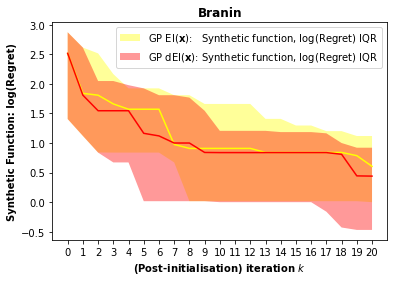

In [163]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


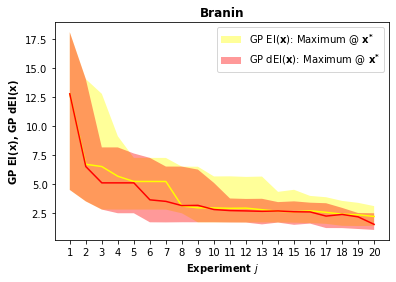

In [164]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approxAF, color = 'Yellow')
plt.plot(median_exactAF, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approxAF, upper_approxAF, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')
plt.fill_between(xstar, lower_exactAF, upper_exactAF, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$), GP dEI($\mathbf{x}$)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualise!


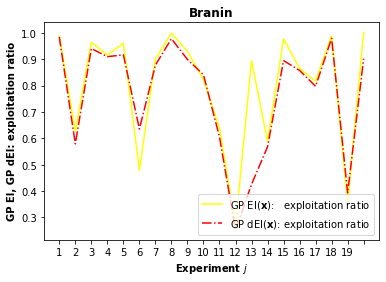

In [165]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(approx_ratio, color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio')
plt.plot(exact_ratio, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=4) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


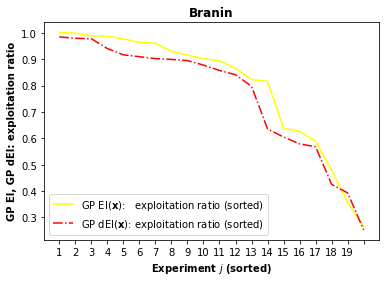

In [166]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(np.sort(approx_ratio)[::-1], color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio (sorted)')
plt.plot(np.sort(exact_ratio)[::-1], color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio (sorted)')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$ (sorted)' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


In [167]:
np.sum((approx_1.start_points_arr - exact_1.start_points_arr)**2)


0.0

In [168]:
approx_mean_test, approx_var_test = surrogate_approx_1.predict(approx_1.start_points_arr,return_std=True)
approx_std_test = np.sqrt(approx_var_test + eps)
approx_mean_test, approx_std_test


(array([ -3.47790593,  -2.96296147, -13.55029386,  -5.65053498,
         -6.35021609,  -9.4435323 ,  -2.1246802 ,  -3.72260049,
        -17.13453858,  -2.3694201 , -38.08859149, -10.10135388,
        -22.19055615,  -5.17394118, -10.94342573,  -4.02601262,
        -79.83532449, -12.96228207,  -9.29184515,  -3.33430781]),
 array([1.73732256, 1.89726515, 1.7968293 , 1.99600151, 1.99911738,
        1.98892616, 1.9833371 , 1.83137236, 1.97398418, 1.93359994,
        1.96566716, 1.92744052, 1.92974439, 1.98838806, 1.90207809,
        1.73821815, 1.77481229, 1.9666001 , 1.98719452, 1.99981128]))

In [169]:
exact_mean_test, exact_var_test = surrogate_exact_1.predict(exact_1.start_points_arr,return_std=True)
exact_std_test = np.sqrt(exact_var_test + eps)
np.round(exact_mean_test, 3), np.round(exact_std_test, 3)


(array([ -4.66 ,  -4.238, -11.591,  -4.615,  -6.668,  -9.91 ,  -2.015,
         -3.576, -18.174,  -3.865, -39.415, -10.312, -19.277,  -3.337,
        -10.823,  -5.361, -79.829, -12.626,  -9.078,  -3.189]),
 array([1.902, 1.766, 1.833, 1.998, 1.999, 1.979, 1.981, 1.954, 1.972,
        1.77 , 1.963, 1.927, 1.953, 1.978, 1.889, 1.87 , 1.775, 1.967,
        1.988, 2.   ]))

In [170]:
-np.min(approx_1.f_best)

4.344791938628157

In [171]:
-np.min(exact_1.f_best)

3.491770143645005